# Importing all the necessary Libs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Sequential, Model
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import pickle
import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy

# Data-Preprocessing

In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Combine training and test sets for both digits and labels
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

all_labels_test = np.concatenate([y_train, y_test])

# Normalize the pixel values of digits to be between 0 and 1
all_digits = all_digits.astype("float32") / 255.0

# Reshape the digits to conform with the input shape required by TensorFlow, adding a channel dimension
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

# Convert labels to one-hot encoding format
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create a TensorFlow dataset for efficient batching and shuffling
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size=100)

# Print the shape of the dataset to verify correctness
print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


# Define configuration parameters for the model

In [4]:
# Batch size for training
batch_size = 100

# Number of color channels in the images (1 for grayscale images like MNIST)
num_channels = 1

# Number of unique classes in the dataset
num_classes = 10

# Size of the images (28x28 pixels for MNIST)
image_size = 28

# Dimensionality of the latent space (input vector for the generator)
latent_dim = 100

# Channels for generator input: combines latent space and class labels
generator_in_channels = latent_dim + num_classes

# Channels for discriminator input: combines image channels and class labels
discriminator_in_channels = num_channels + num_classes

# Print the calculated channel sizes for generator and discriminator inputs
print(f"Generator Input Channels: {generator_in_channels}, Discriminator Input Channels: {discriminator_in_channels}")


Generator Input Channels: 110, Discriminator Input Channels: 11


# Defining Discriminator Network

In [5]:
def create_discriminator():
    """
    Creates the discriminator model for a GAN.
    
    The discriminator is a convolutional neural network that classifies images as real or fake.
    It takes 28x28 images with 11 channels as input.
    
    Returns:
        A Keras Sequential model representing the discriminator.
    """
    model = keras.Sequential(
        [
            # Input layer specifying the shape of input images
            keras.layers.InputLayer((28, 28, 11)),
            
            # First convolutional layer with LeakyReLU to allow a small, negative slope for non-active neurons
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            
            # Second convolutional layer to learn more complex features, again with LeakyReLU
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            
            # Global Max Pooling to reduce the spatial dimensions
            layers.GlobalMaxPooling2D(),
            
            # Output layer with a single neuron for binary classification, using sigmoid activation
            layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
    
    return model

# Create and review the discriminator model
discriminator = create_discriminator()
print(discriminator.summary())



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        6400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Glob  (None, 128)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                    

# Defining Generator Network

In [6]:
def create_generator():
    """
    Creates the generator model for a GAN.
    
    The generator is a convolutional neural network that generates fake images from a noise vector.
    It starts with a dense layer that reshapes into a 7x7 128-channel feature map, then up-samples to a 28x28 image.
    
    Returns:
        A Keras Sequential model representing the generator.
    """
    model = keras.Sequential(
        [
            # Input layer for the generator taking a noise vector
            keras.layers.InputLayer((110,)),
            
            # Dense layer that is reshaped into a feature map
            layers.Dense(7 * 7 * 128),
            layers.LeakyReLU(alpha=0.2),
            
            # Reshape the output into a feature map of shape (7, 7, 128)
            layers.Reshape((7, 7, 128)),
            
            # Upsample to a larger feature map using transposed convolutions
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            
            # Further upsample to approach the target image size
            layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            
            # Final convolution to produce the output image with desired dimensions and single channel
            layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    
    return model

# Create and review the generator model
generator = create_generator()
print(generator.summary())


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              696192    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        131136    
 Transpose)                                              

# Defining Custom Training Loop

In [7]:
class ConditionalGAN(keras.Model):
    """
    Conditional Generative Adversarial Network (Conditional GAN) class.
    
    This class encapsulates a generator and discriminator model for generating images conditioned on labels.
    
    Attributes:
        discriminator: The discriminator model distinguishes real images from fake.
        generator: The generator model generates fake images given noise and labels.
        latent_dim: Dimensionality of the latent space.
        gen_loss_tracker: Tracker for generator's loss over time.
        disc_loss_tracker: Tracker for discriminator's loss over time.
        real_accuracy_tracker: Tracker for accuracy on real images.
        fake_accuracy_tracker: Tracker for accuracy on fake images.
    """
    
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.real_accuracy_tracker = keras.metrics.Mean(name="real_image_accuracy")
        self.fake_accuracy_tracker = keras.metrics.Mean(name="fake_image_accuracy")

    @property
    def metrics(self):
        """Returns the list of trackers for monitoring the training process."""
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.real_accuracy_tracker, self.fake_accuracy_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        """
        Configures the ConditionalGAN for training.
        
        Parameters:
            d_optimizer: Optimizer for the discriminator.
            g_optimizer: Optimizer for the generator.
            loss_fn: Loss function to be used for optimization.
        """
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        """
        Custom training logic for one iteration.
        
        Parameters:
            data: Tuple containing real images and their corresponding one-hot labels.
            
        Returns:
            A dictionary mapping metric names to their current value.
        """
        real_images, one_hot_labels = data

        # Prepare label embeddings to concatenate with images for conditional GAN
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))

        # Generate noise and concatenate with labels to feed into the generator
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Generate fake images and prepare inputs for the discriminator
        generated_images = self.generator(random_vector_labels)
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        # Labels for training the discriminator
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Misleading labels for the generator training (all labels as 'real')
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.fake_accuracy_tracker.update_state(tf.reduce_mean(predictions))
        self.real_accuracy_tracker.update_state(tf.reduce_mean(self.discriminator(real_image_and_labels)))

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "r_acc": self.real_accuracy_tracker.result(),
            "f_acc": self.fake_accuracy_tracker.result(),
        }


# Defining custom callback class for training visualization

In [8]:
class Visualizer(keras.callbacks.Callback):
    """
    A Keras Callback class for visualizing the output of generator and discriminator during training.
    """
    
    def __init__(self, generator_test, discriminator_test, real_images, real_labels):
        """
        Initializes the visualizer with the test models, real images, and labels.
        
        Parameters:
            generator_test (tf.Model): The generator model to generate images for testing.
            discriminator_test (tf.Model): The discriminator model to classify images.
            real_images (np.array): An array of real images.
            real_labels (np.array): An array of labels corresponding to the real images.
        """
        super().__init__()
        self.generator_test = generator_test
        self.discriminator_test = discriminator_test
        self.latent_dim = 100  # Fixed dimension for latent space
        self.real_images = real_images
        self.real_labels = real_labels

    def on_train_end(self, logs=None):
        """Saves the models after training completes."""
        # Save generator and discriminator models at the end of training
        self.generator_test.save('p1_gen.h5')
        self.discriminator_test.save('p1_dis.h5')

    def on_epoch_end(self, epoch, logs=None):
        """
        Operations to perform at the end of each epoch.
        
        Generates images, evaluates them with the discriminator, and plots the results.
        """
        # Generate one-hot labels for digits 0-9
        one_hot_labels = tf.one_hot(tf.range(10), 10)
        # Generate random latent vectors
        random_latent_vectors = tf.random.normal(shape=(10, self.latent_dim))
        # Concatenate latent vectors with labels for conditional generation
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        # Generate images
        generated_images = self.generator_test(random_vector_labels)

        # Get real images and their labels for testing
        real_images_and_labels, real_images_plotting = self.get_real_image_and_labels()
        # Prepare fake images and labels for testing
        fake_images_and_labels = self.get_fake_images_and_labels(generated_images, one_hot_labels)

        # Evaluate real and fake images using the discriminator
        discriminator_output_real_images = self.discriminator_test(real_images_and_labels)
        discriminator_output_fake_images = self.discriminator_test(fake_images_and_labels)

        # Plot real and fake images along with discriminator outputs
        self.plot_images_with_disoutput(real_images_plotting, discriminator_output_real_images, 'Real Images')
        self.plot_images_with_disoutput(generated_images, discriminator_output_fake_images, 'Fake Images')

    def get_fake_images_and_labels(self, generated_images, one_hot_labels):
        """
        Prepares fake images and corresponding labels for discriminator evaluation.
        
        Parameters:
            generated_images (tf.Tensor): Generated images from the generator.
            one_hot_labels (tf.Tensor): One-hot encoded labels.
            
        Returns:
            tf.Tensor: Concatenated fake images and labels tensor.
        """
        # Repeat and reshape one-hot labels to match image dimensions
        image_one_hot_labels_test = tf.repeat(one_hot_labels, repeats=[28 * 28])
        image_one_hot_labels_test = tf.reshape(image_one_hot_labels_test, (-1, 28, 28, 10))
        # Concatenate generated images with their labels
        fake_images_and_labels = tf.concat([generated_images, image_one_hot_labels_test], -1)
        return fake_images_and_labels



    def get_real_image_and_labels(self):
        """
        Selects real images for testing and prepares them with labels.
        Adds checks to handle classes with no images and improves error handling.
        
        Returns:
            Tuple of tf.Tensor and list: Concatenated real images with labels tensor, and list of images for plotting.
            Raises a ValueError if no real images are found for any class.
        """
        real_images_plotting = []
        selected_labels = []

        # Iterate over each class label expected in the dataset
        for class_label in range(10):
            class_indices = np.where(self.real_labels == class_label)[0]
            
            if class_indices.size == 0:
                print(f"No images found for class {class_label}. Skipping this class.")
                continue
            
            selected_index = np.random.choice(class_indices, size=1, replace=False)
            real_image = np.squeeze(self.real_images[selected_index])
            real_images_plotting.append(real_image)
            selected_labels.append(tf.one_hot(class_label, 10))

        if not real_images_plotting:
            # If no images were selected for plotting, raise an error
            raise ValueError("No real images were found for any class.")

        # Stack images and labels for further processing
        selected_images_stacked = np.stack(real_images_plotting).reshape(-1, 28, 28, 1)
        selected_labels_stacked = tf.stack(selected_labels)

        # Repeat and reshape labels to match the dimensions of the images
        image_one_hot_labels = tf.repeat(selected_labels_stacked, repeats=28 * 28, axis=0)
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, 28, 28, 10))
        
        # Concatenate images with their respective one-hot encoded labels
        real_images_and_labels = tf.concat([selected_images_stacked, image_one_hot_labels], axis=-1)

        return real_images_and_labels, real_images_plotting



    def plot_images_with_disoutput(self, images_for_plotting, discriminator_output, title):
        """
        Plots images alongside the discriminator's output for each.
        
        Parameters:
            images_for_plotting (list of np.array): Images to plot.
            discriminator_output (tf.Tensor): Discriminator output for each image.
            title (str): Title for the plot group.
        """
        # Setup plot
        fig, axs = plt.subplots(1, 10, figsize=(18, 2))
        # Plot each image with discriminator output
        for i, (image, label) in enumerate(zip(images_for_plotting, discriminator_output)):
            axs[i].imshow(image, cmap='gray')
            axs[i].axis('off')
            # Ensure label is a scalar by extracting the first element if necessary
            scalar_label = label.numpy().flatten()[0]  # Convert to numpy, flatten and take the first value
            axs[i].set_title(f"{scalar_label:.2f}")  # Show discriminator output as title
        fig.suptitle(title)
        plt.show()

        




Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              696192    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 64)        131136    
 Transpose)                                              

c:\Users\anant\.conda\envs\gpu-env\lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


700/700 [==============================] - ETA: 0s - g_loss: 1.0173 - d_loss: 0.5540 - r_acc: 0.5978 - f_acc: 0.3878

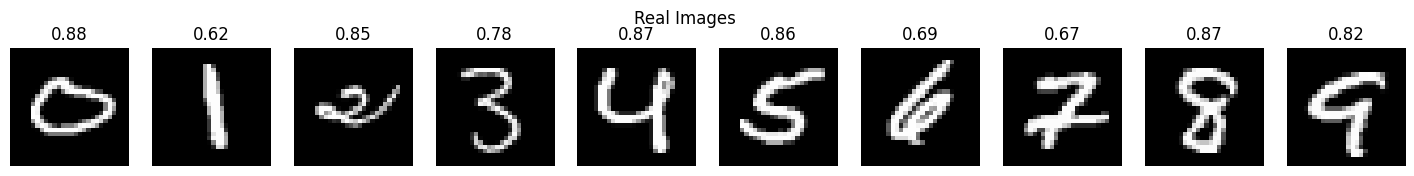

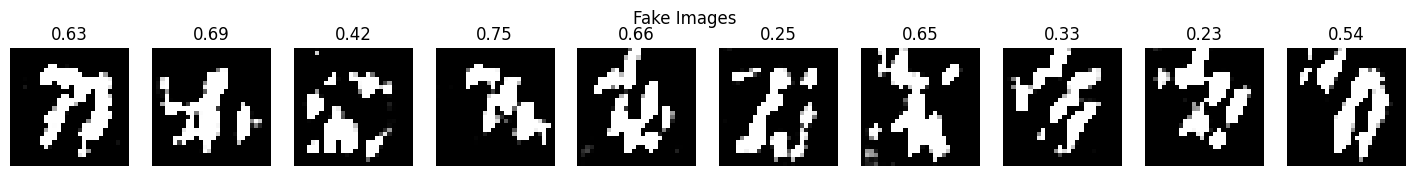

700/700 [==============================] - 57s 80ms/step - g_loss: 1.0174 - d_loss: 0.5539 - r_acc: 0.5978 - f_acc: 0.3878
Epoch 2/100
700/700 [==============================] - ETA: 0s - g_loss: 0.9556 - d_loss: 0.5811 - r_acc: 0.5799 - f_acc: 0.4074

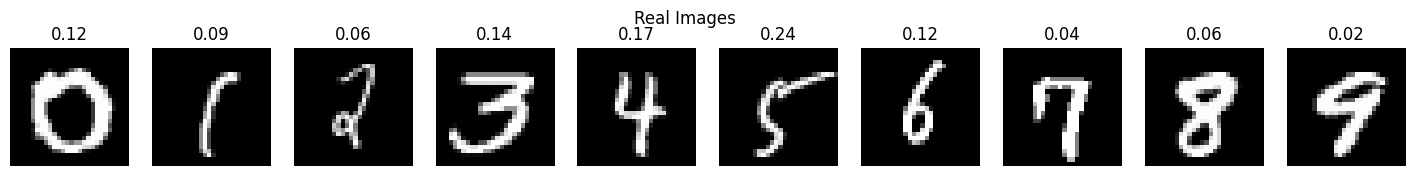

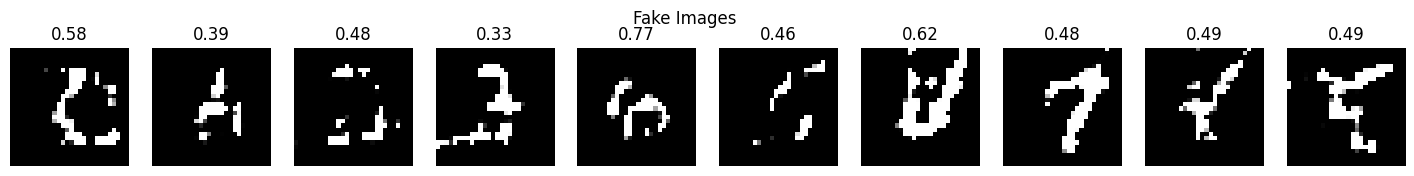

700/700 [==============================] - 55s 78ms/step - g_loss: 0.9556 - d_loss: 0.5811 - r_acc: 0.5800 - f_acc: 0.4074
Epoch 3/100
700/700 [==============================] - ETA: 0s - g_loss: 1.0782 - d_loss: 0.5383 - r_acc: 0.6143 - f_acc: 0.3736

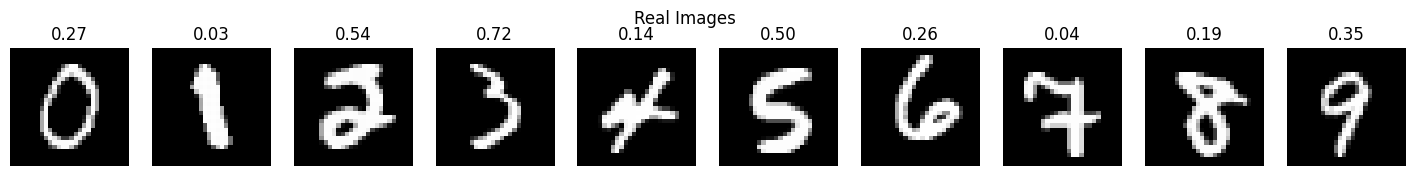

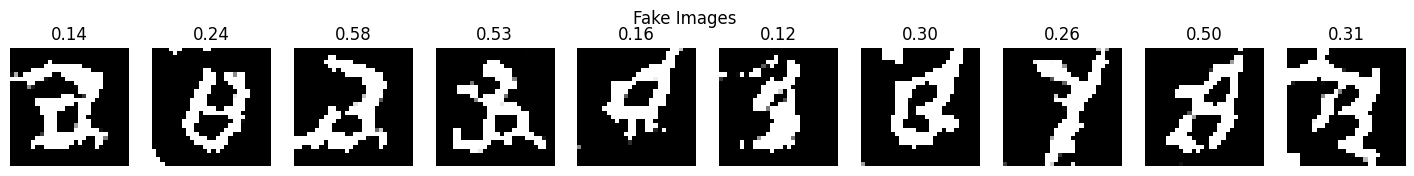

700/700 [==============================] - 56s 80ms/step - g_loss: 1.0783 - d_loss: 0.5383 - r_acc: 0.6143 - f_acc: 0.3736
Epoch 4/100
700/700 [==============================] - ETA: 0s - g_loss: 1.2753 - d_loss: 0.4575 - r_acc: 0.6611 - f_acc: 0.3240

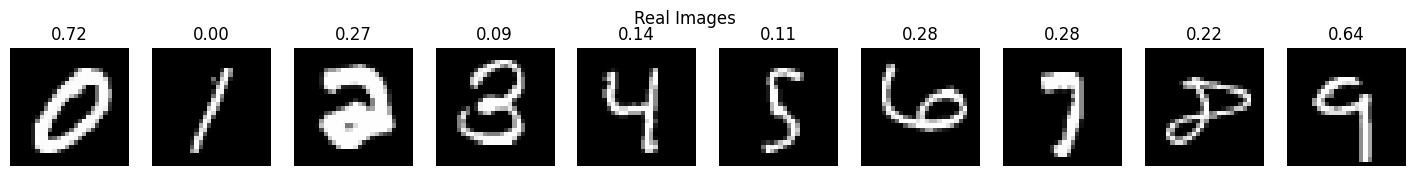

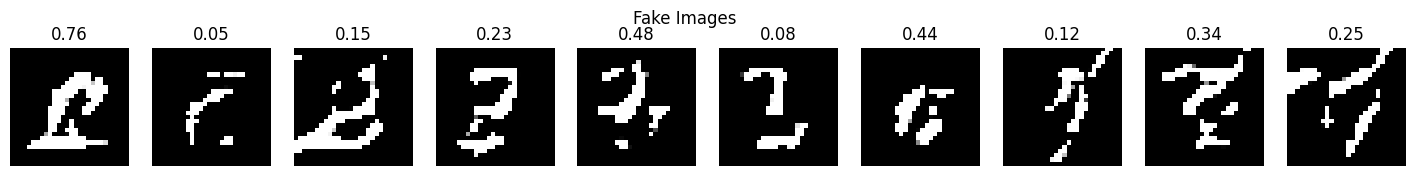

700/700 [==============================] - 55s 78ms/step - g_loss: 1.2756 - d_loss: 0.4574 - r_acc: 0.6611 - f_acc: 0.3240
Epoch 5/100
700/700 [==============================] - ETA: 0s - g_loss: 1.7338 - d_loss: 0.3180 - r_acc: 0.7535 - f_acc: 0.2315

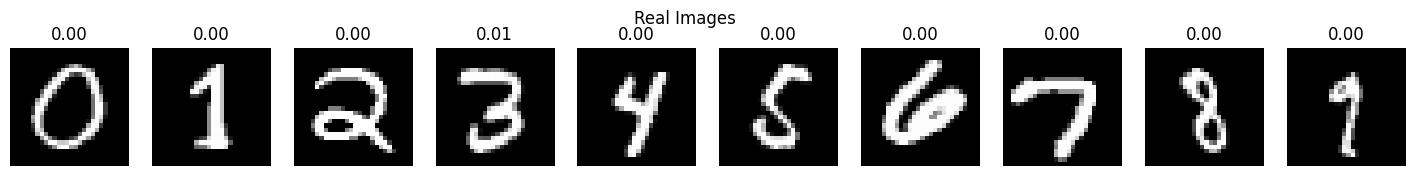

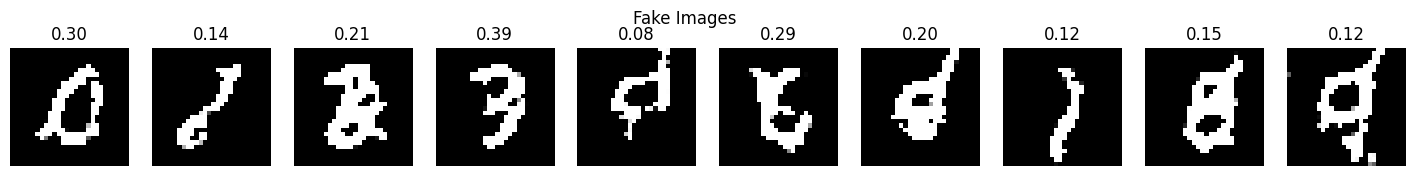

700/700 [==============================] - 54s 77ms/step - g_loss: 1.7340 - d_loss: 0.3179 - r_acc: 0.7535 - f_acc: 0.2314
Epoch 6/100
700/700 [==============================] - ETA: 0s - g_loss: 2.2868 - d_loss: 0.1761 - r_acc: 0.8512 - f_acc: 0.1437

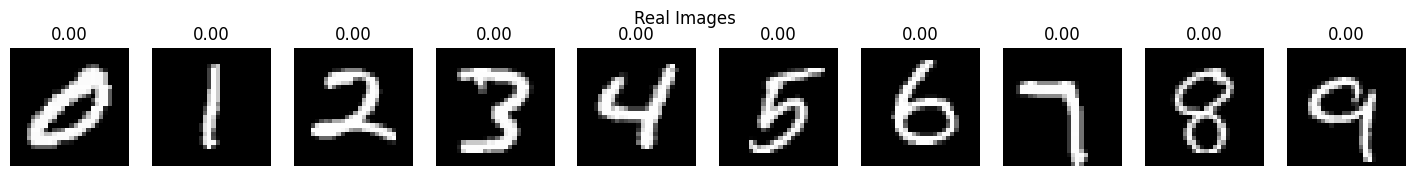

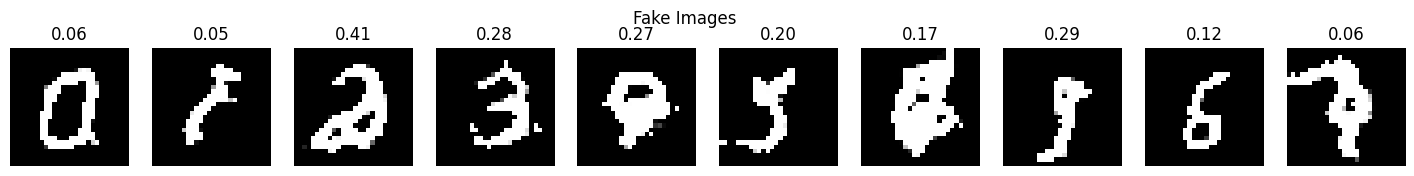

700/700 [==============================] - 54s 78ms/step - g_loss: 2.2870 - d_loss: 0.1761 - r_acc: 0.8512 - f_acc: 0.1437
Epoch 7/100
700/700 [==============================] - ETA: 0s - g_loss: 2.3696 - d_loss: 0.2281 - r_acc: 0.8317 - f_acc: 0.1633

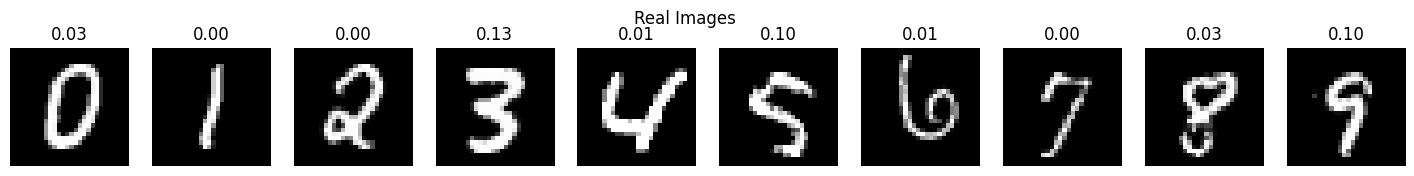

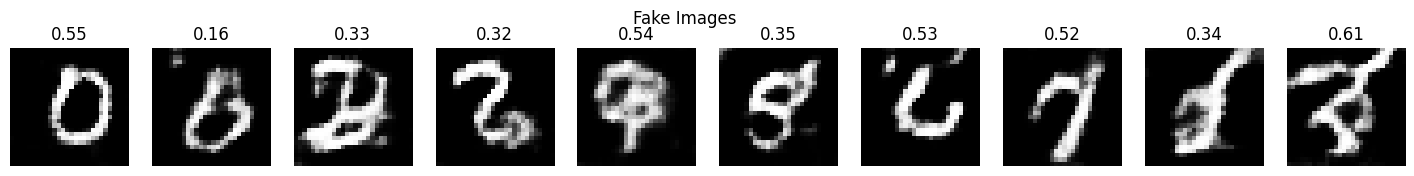

700/700 [==============================] - 54s 77ms/step - g_loss: 2.3686 - d_loss: 0.2284 - r_acc: 0.8316 - f_acc: 0.1635
Epoch 8/100
700/700 [==============================] - ETA: 0s - g_loss: 0.9369 - d_loss: 0.6322 - r_acc: 0.5677 - f_acc: 0.4299

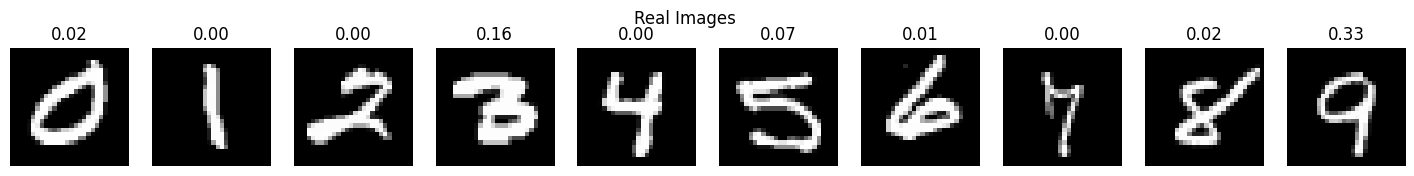

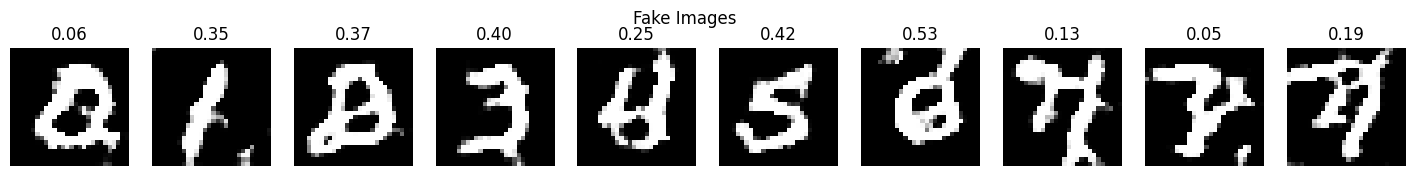

700/700 [==============================] - 55s 79ms/step - g_loss: 0.9370 - d_loss: 0.6322 - r_acc: 0.5677 - f_acc: 0.4299
Epoch 9/100
700/700 [==============================] - ETA: 0s - g_loss: 1.0631 - d_loss: 0.6241 - r_acc: 0.5849 - f_acc: 0.4018

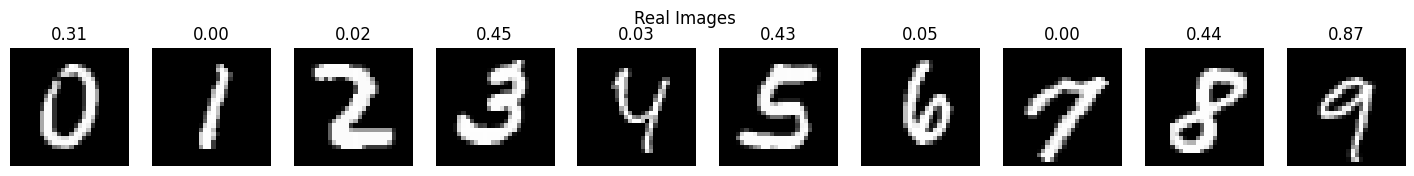

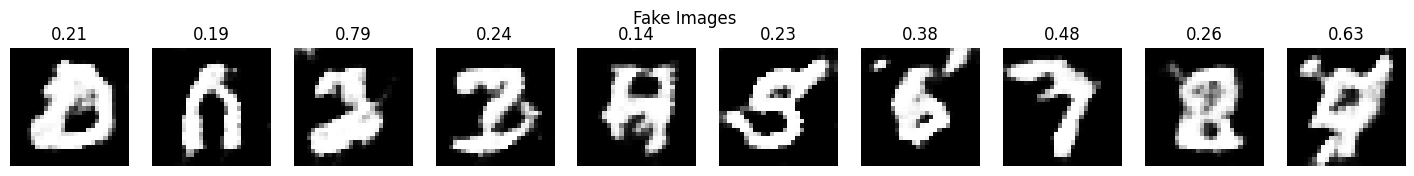

700/700 [==============================] - 54s 77ms/step - g_loss: 1.0629 - d_loss: 0.6241 - r_acc: 0.5848 - f_acc: 0.4018
Epoch 10/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8354 - d_loss: 0.6794 - r_acc: 0.5360 - f_acc: 0.4570

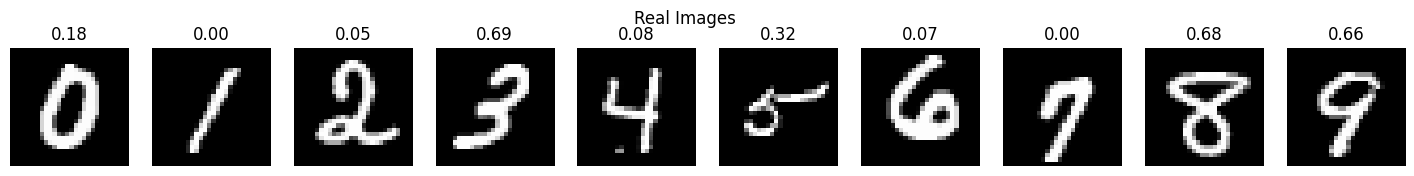

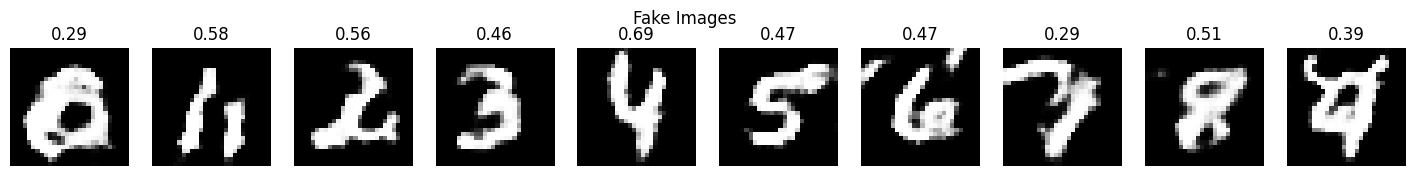

700/700 [==============================] - 54s 77ms/step - g_loss: 0.8354 - d_loss: 0.6794 - r_acc: 0.5360 - f_acc: 0.4570
Epoch 11/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8042 - d_loss: 0.6888 - r_acc: 0.5269 - f_acc: 0.4660

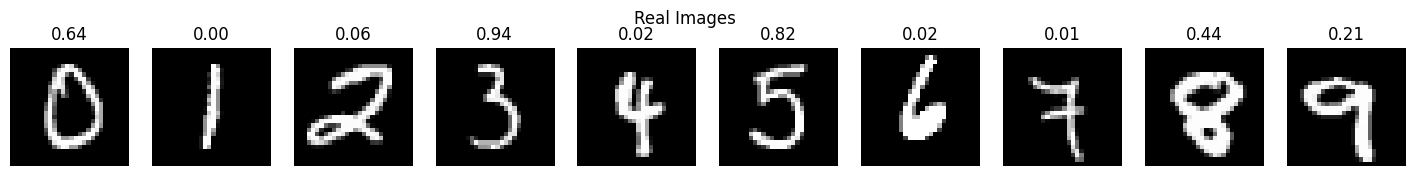

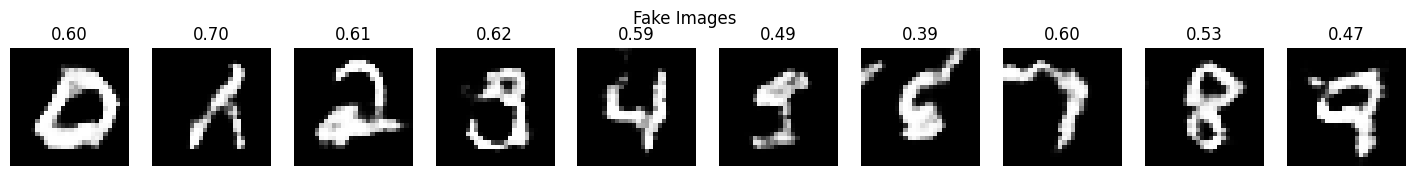

700/700 [==============================] - 54s 78ms/step - g_loss: 0.8042 - d_loss: 0.6888 - r_acc: 0.5269 - f_acc: 0.4660
Epoch 12/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7684 - d_loss: 0.6942 - r_acc: 0.5187 - f_acc: 0.4778

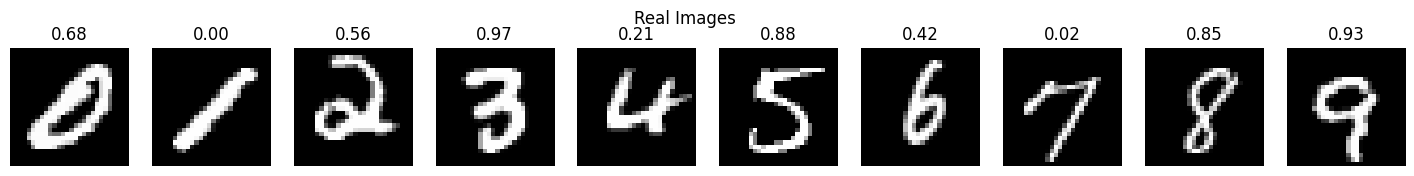

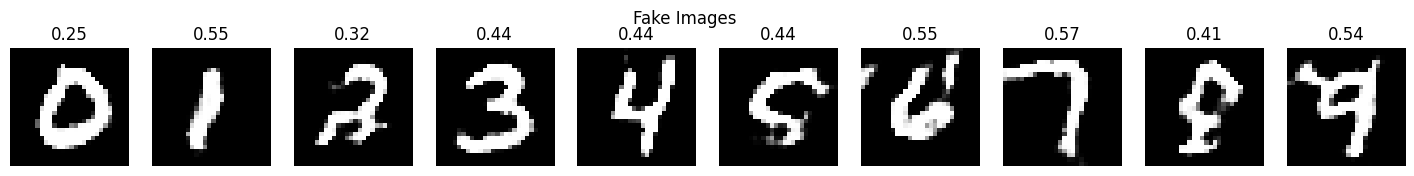

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7684 - d_loss: 0.6941 - r_acc: 0.5187 - f_acc: 0.4778
Epoch 13/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7815 - d_loss: 0.6883 - r_acc: 0.5198 - f_acc: 0.4718

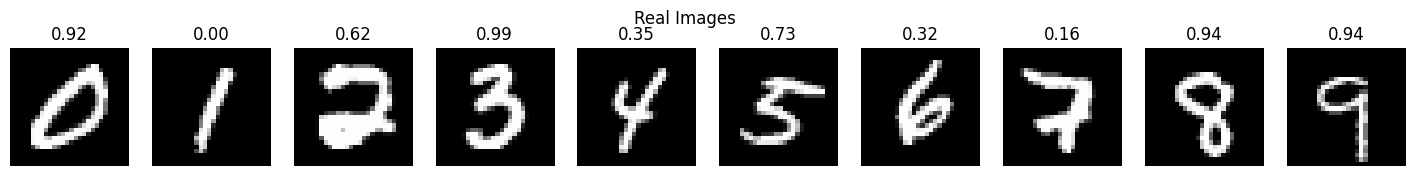

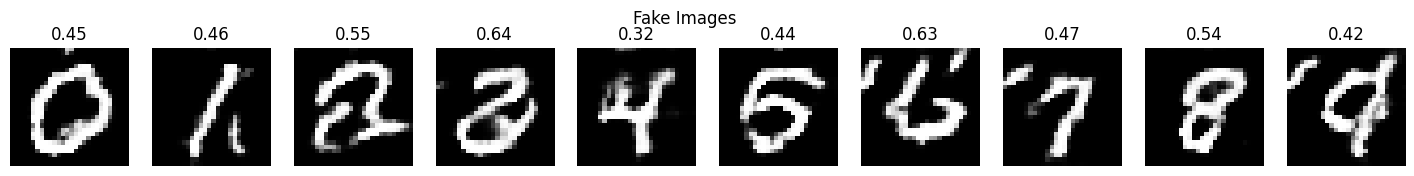

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7815 - d_loss: 0.6883 - r_acc: 0.5198 - f_acc: 0.4718
Epoch 14/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7738 - d_loss: 0.6926 - r_acc: 0.5165 - f_acc: 0.4737

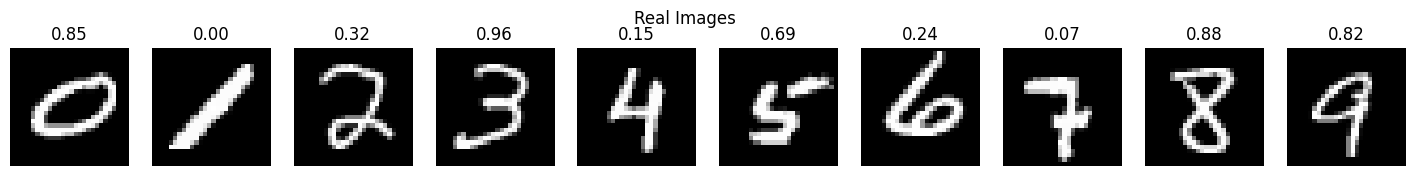

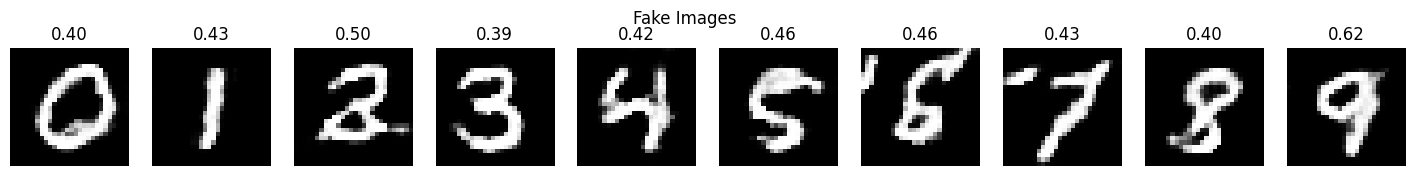

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7738 - d_loss: 0.6926 - r_acc: 0.5165 - f_acc: 0.4737
Epoch 15/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7270 - d_loss: 0.7002 - r_acc: 0.5063 - f_acc: 0.4901

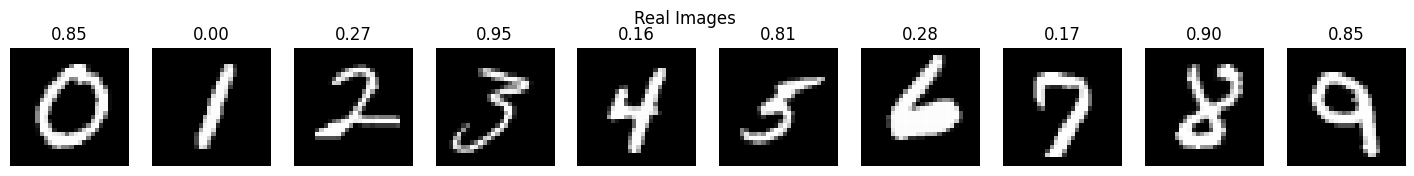

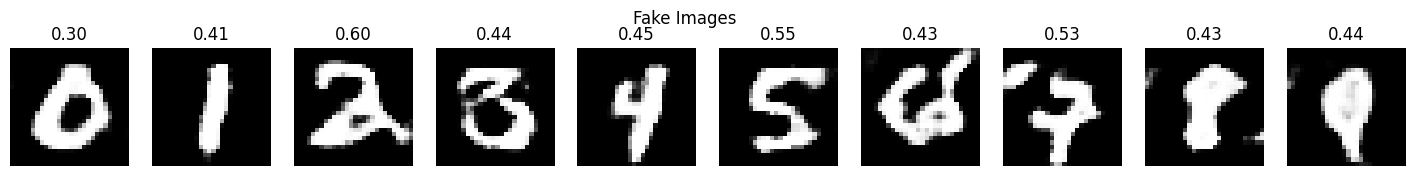

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7270 - d_loss: 0.7002 - r_acc: 0.5063 - f_acc: 0.4901
Epoch 16/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7679 - d_loss: 0.6878 - r_acc: 0.5167 - f_acc: 0.4754

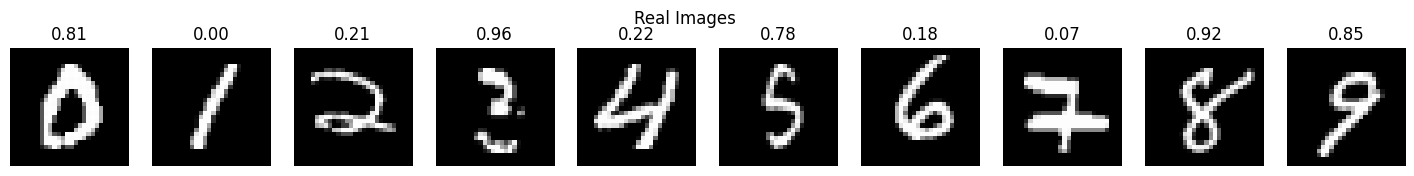

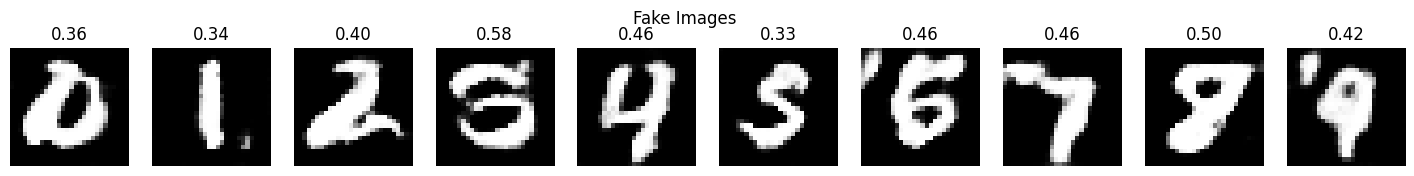

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7679 - d_loss: 0.6878 - r_acc: 0.5167 - f_acc: 0.4754
Epoch 17/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7495 - d_loss: 0.6926 - r_acc: 0.5114 - f_acc: 0.4811

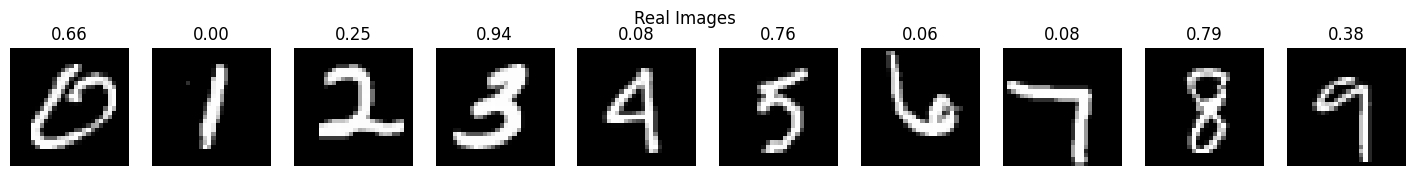

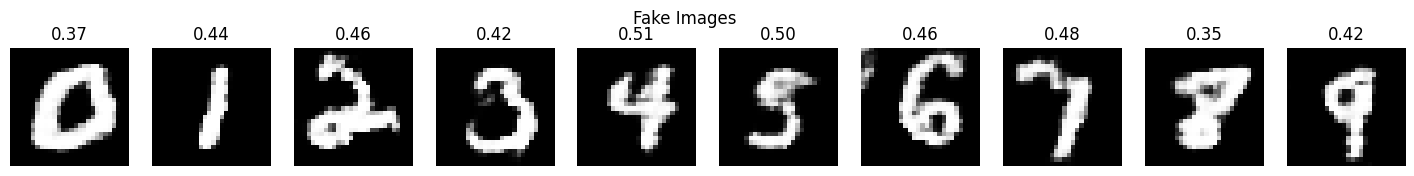

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7494 - d_loss: 0.6927 - r_acc: 0.5114 - f_acc: 0.4812
Epoch 18/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7261 - d_loss: 0.6978 - r_acc: 0.5058 - f_acc: 0.4894

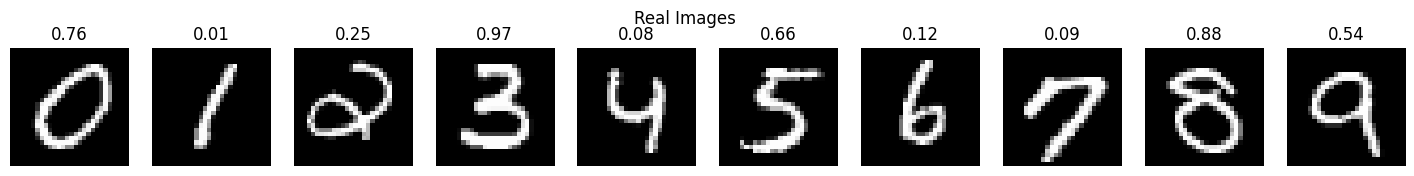

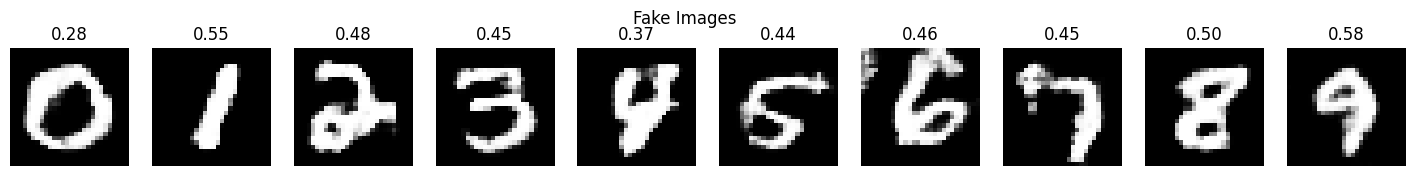

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7261 - d_loss: 0.6978 - r_acc: 0.5058 - f_acc: 0.4894
Epoch 19/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7361 - d_loss: 0.6934 - r_acc: 0.5087 - f_acc: 0.4856

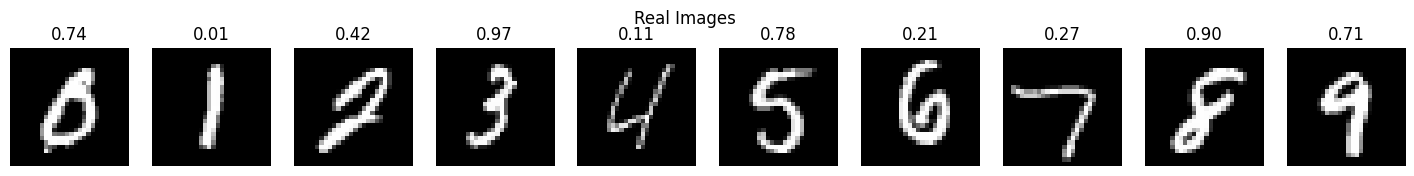

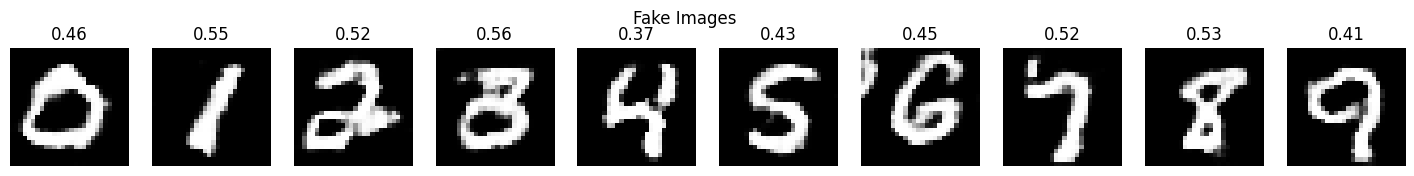

700/700 [==============================] - 54s 78ms/step - g_loss: 0.7360 - d_loss: 0.6934 - r_acc: 0.5087 - f_acc: 0.4856
Epoch 20/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7261 - d_loss: 0.6944 - r_acc: 0.5058 - f_acc: 0.4884

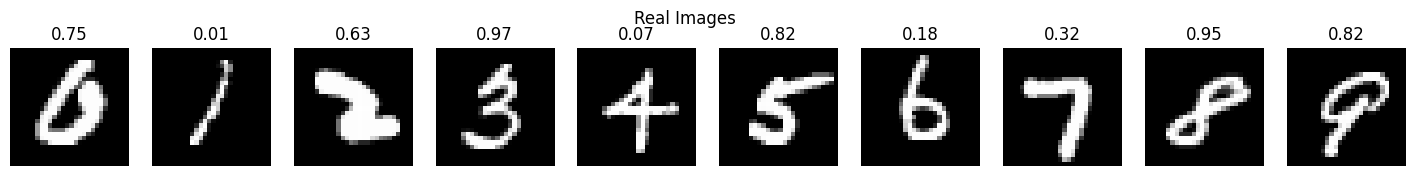

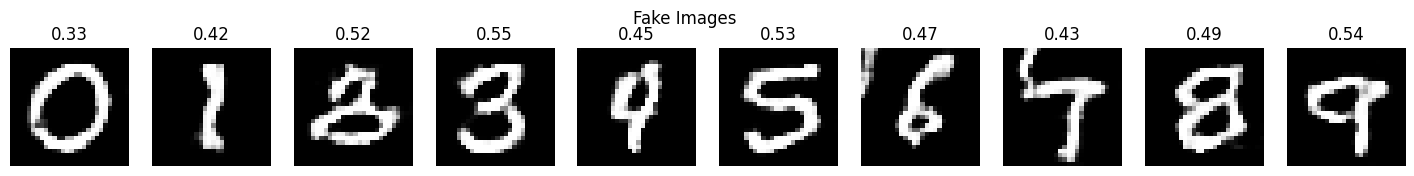

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7261 - d_loss: 0.6944 - r_acc: 0.5058 - f_acc: 0.4884
Epoch 21/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7157 - d_loss: 0.6975 - r_acc: 0.5024 - f_acc: 0.4926

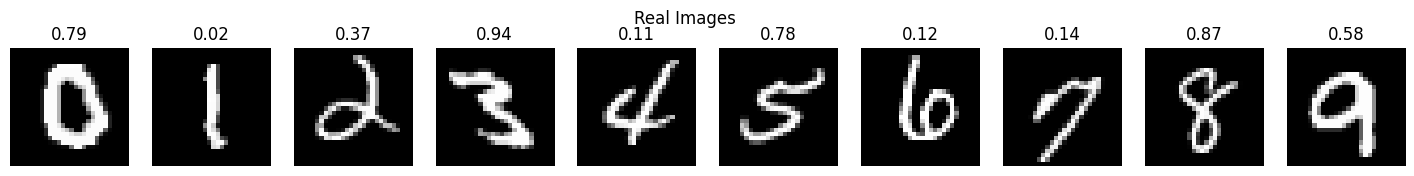

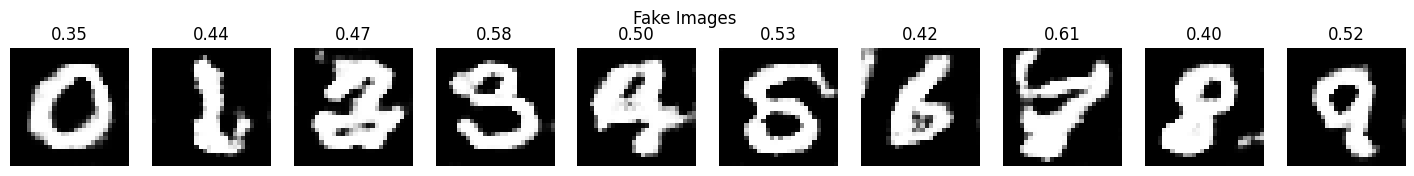

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7157 - d_loss: 0.6975 - r_acc: 0.5024 - f_acc: 0.4926
Epoch 22/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7260 - d_loss: 0.6935 - r_acc: 0.5057 - f_acc: 0.4882

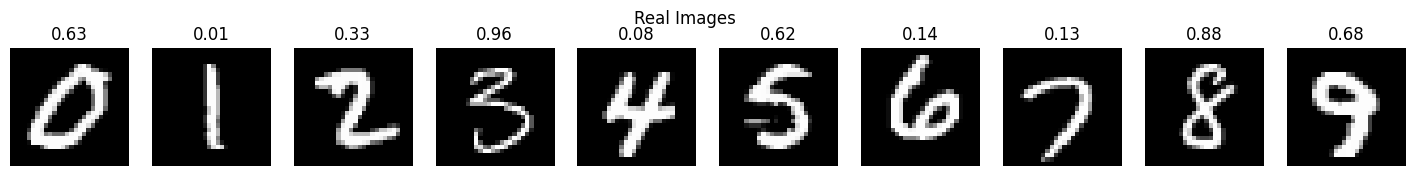

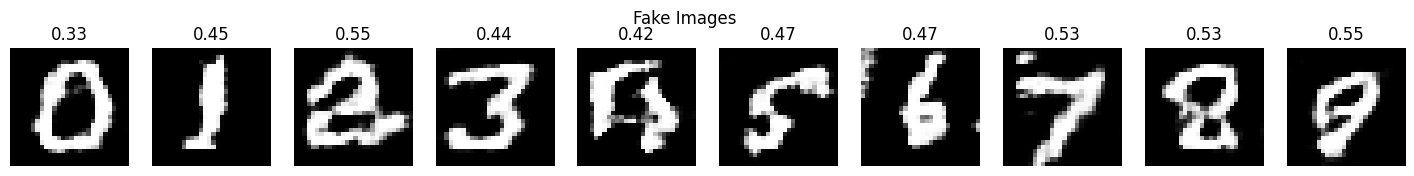

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7260 - d_loss: 0.6935 - r_acc: 0.5057 - f_acc: 0.4882
Epoch 23/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7258 - d_loss: 0.6915 - r_acc: 0.5063 - f_acc: 0.4883

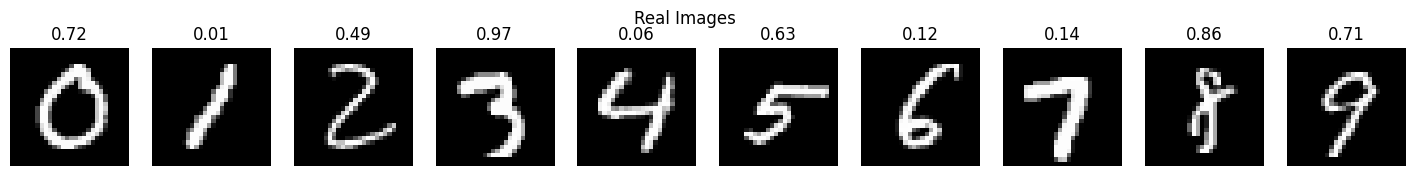

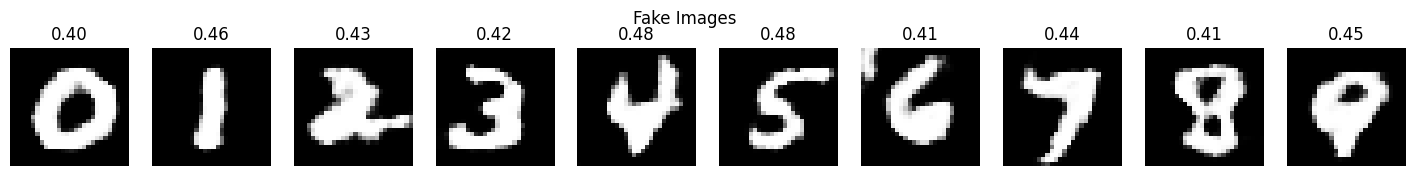

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7258 - d_loss: 0.6915 - r_acc: 0.5063 - f_acc: 0.4883
Epoch 24/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7199 - d_loss: 0.6935 - r_acc: 0.5056 - f_acc: 0.4907

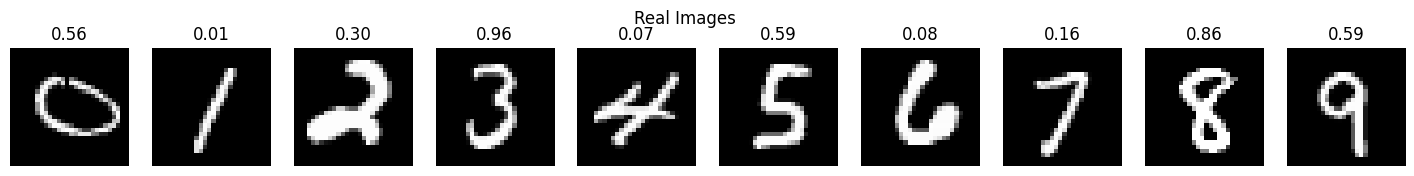

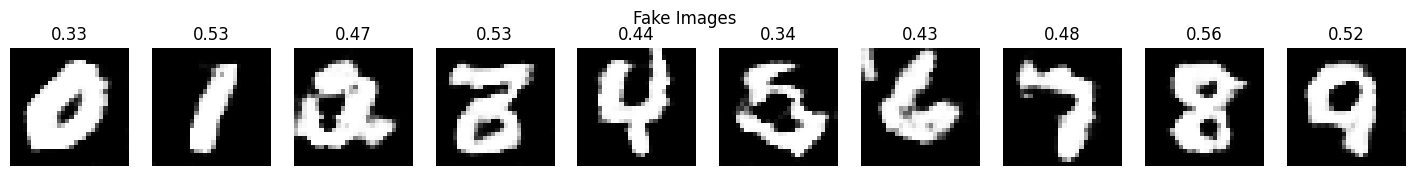

700/700 [==============================] - 55s 79ms/step - g_loss: 0.7199 - d_loss: 0.6935 - r_acc: 0.5056 - f_acc: 0.4907
Epoch 25/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7457 - d_loss: 0.6816 - r_acc: 0.5131 - f_acc: 0.4801

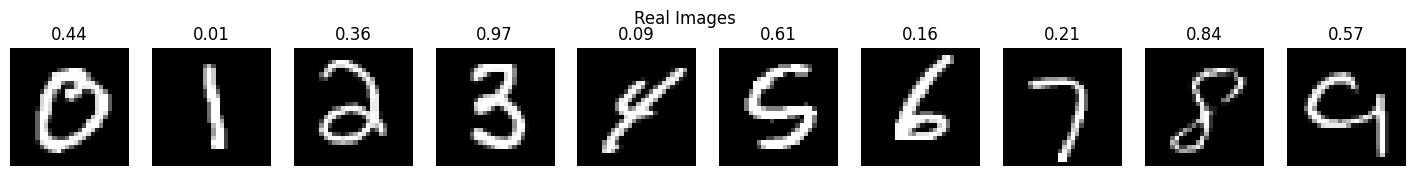

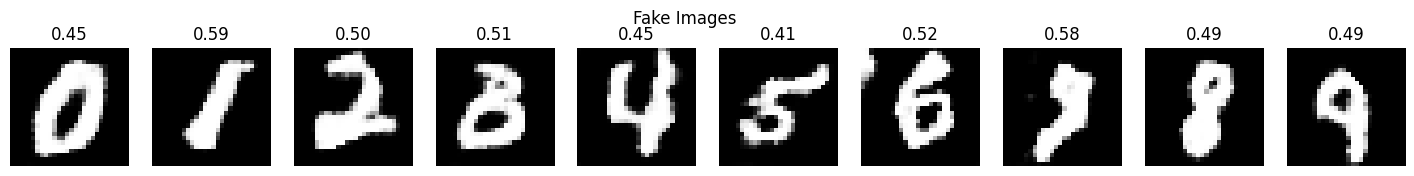

700/700 [==============================] - 55s 79ms/step - g_loss: 0.7457 - d_loss: 0.6816 - r_acc: 0.5131 - f_acc: 0.4801
Epoch 26/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7245 - d_loss: 0.6915 - r_acc: 0.5062 - f_acc: 0.4884

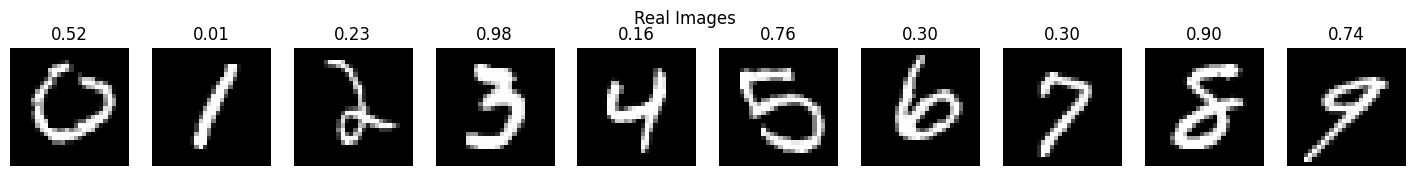

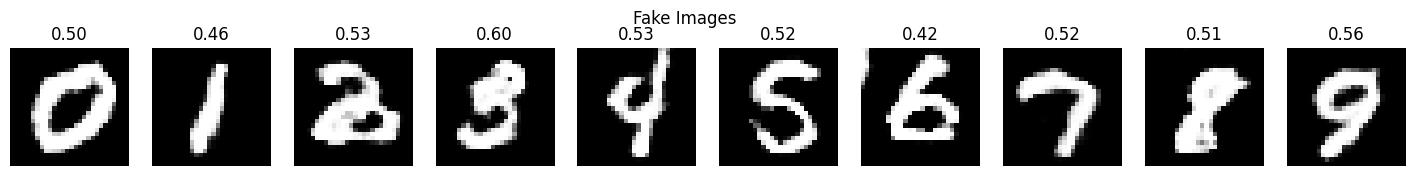

700/700 [==============================] - 56s 79ms/step - g_loss: 0.7245 - d_loss: 0.6915 - r_acc: 0.5062 - f_acc: 0.4884
Epoch 27/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7220 - d_loss: 0.6921 - r_acc: 0.5055 - f_acc: 0.4893

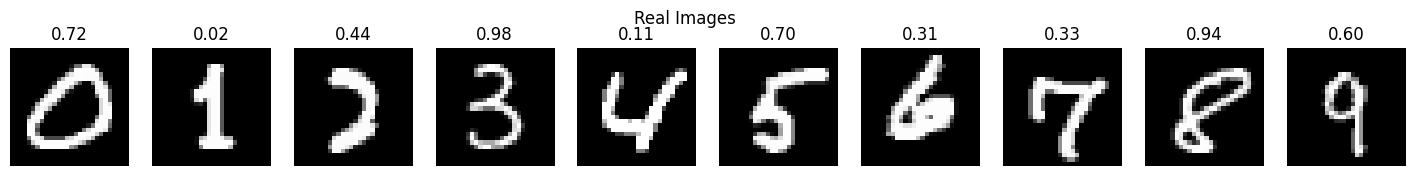

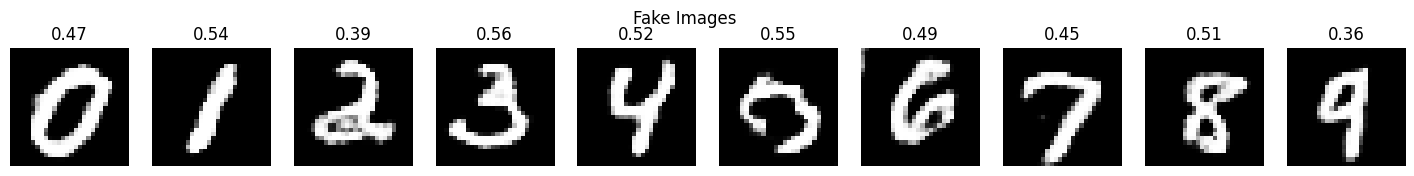

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7220 - d_loss: 0.6921 - r_acc: 0.5055 - f_acc: 0.4893
Epoch 28/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7253 - d_loss: 0.6917 - r_acc: 0.5060 - f_acc: 0.4880

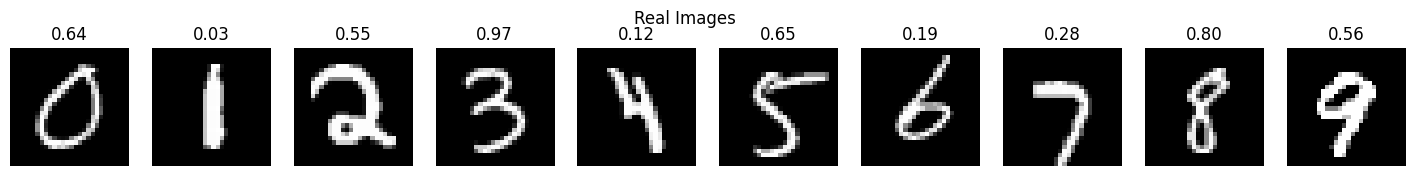

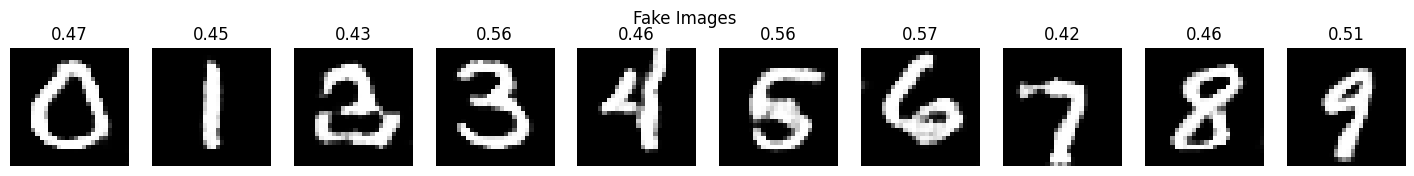

700/700 [==============================] - 56s 80ms/step - g_loss: 0.7253 - d_loss: 0.6917 - r_acc: 0.5060 - f_acc: 0.4880
Epoch 29/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7218 - d_loss: 0.6891 - r_acc: 0.5057 - f_acc: 0.4889

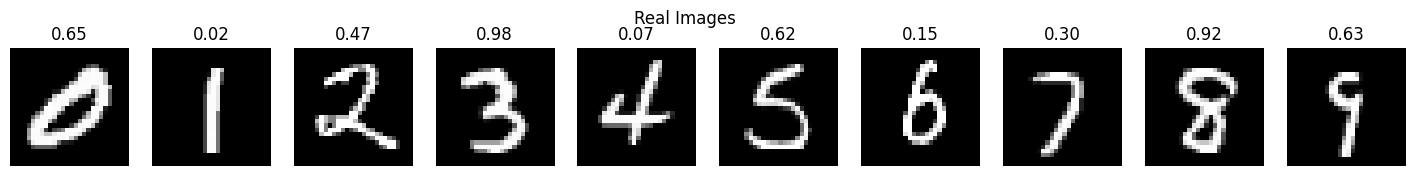

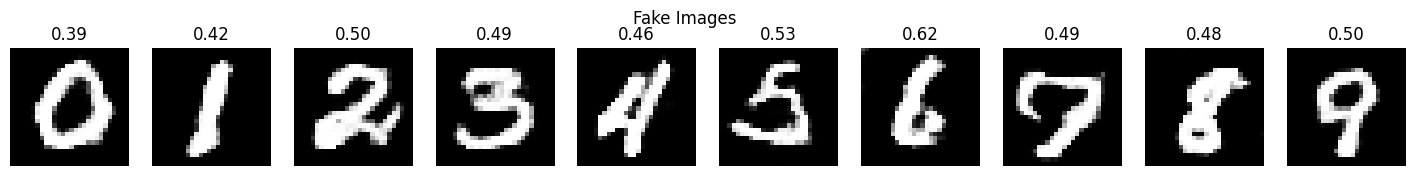

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7218 - d_loss: 0.6891 - r_acc: 0.5057 - f_acc: 0.4889
Epoch 30/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7471 - d_loss: 0.6788 - r_acc: 0.5142 - f_acc: 0.4794

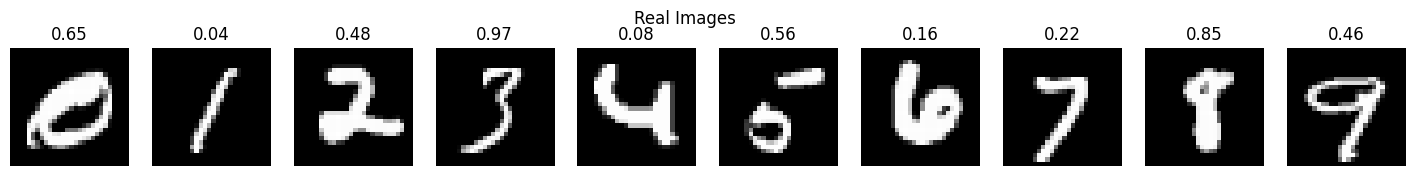

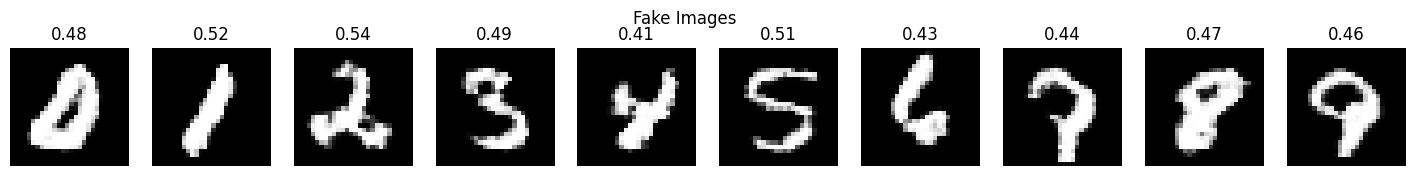

700/700 [==============================] - 55s 79ms/step - g_loss: 0.7471 - d_loss: 0.6789 - r_acc: 0.5141 - f_acc: 0.4794
Epoch 31/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7186 - d_loss: 0.6878 - r_acc: 0.5065 - f_acc: 0.4899

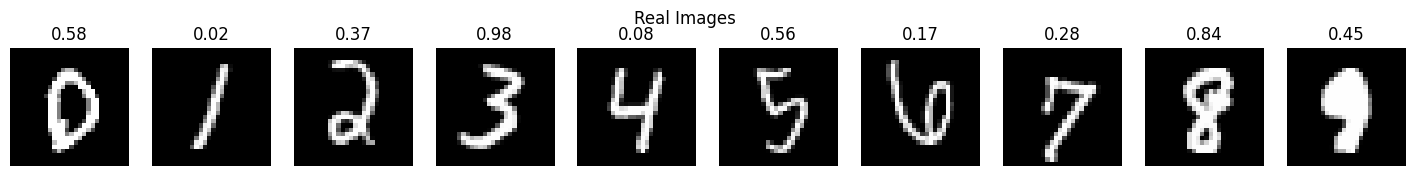

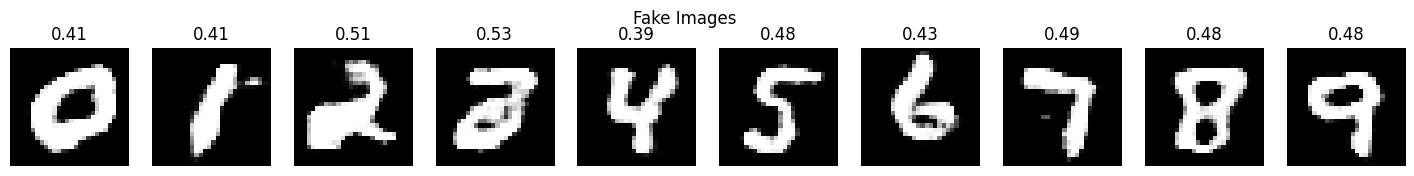

700/700 [==============================] - 55s 79ms/step - g_loss: 0.7186 - d_loss: 0.6878 - r_acc: 0.5065 - f_acc: 0.4899
Epoch 32/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7413 - d_loss: 0.6801 - r_acc: 0.5129 - f_acc: 0.4812

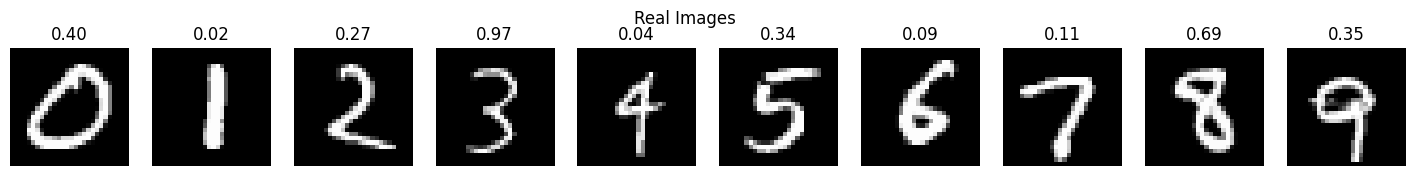

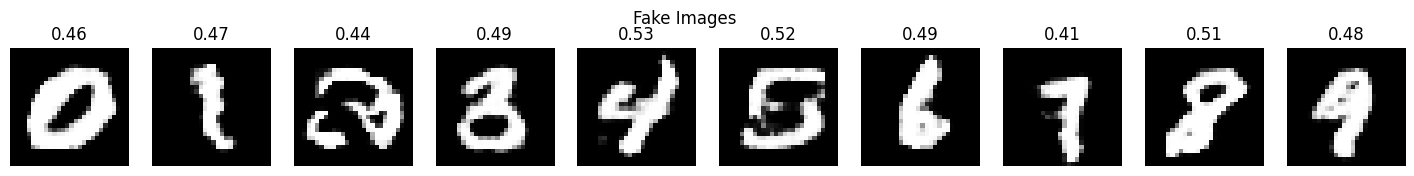

700/700 [==============================] - 56s 80ms/step - g_loss: 0.7412 - d_loss: 0.6801 - r_acc: 0.5129 - f_acc: 0.4812
Epoch 33/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7304 - d_loss: 0.6805 - r_acc: 0.5108 - f_acc: 0.4849

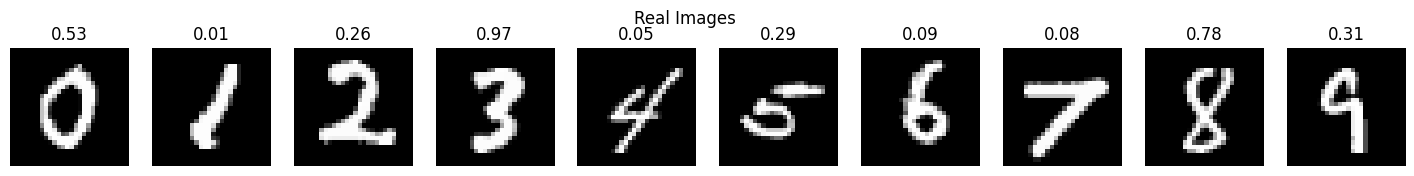

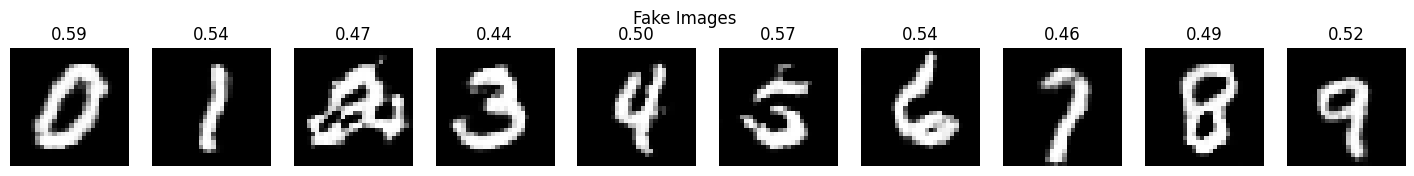

700/700 [==============================] - 59s 84ms/step - g_loss: 0.7304 - d_loss: 0.6805 - r_acc: 0.5108 - f_acc: 0.4849
Epoch 34/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7198 - d_loss: 0.6848 - r_acc: 0.5075 - f_acc: 0.4893

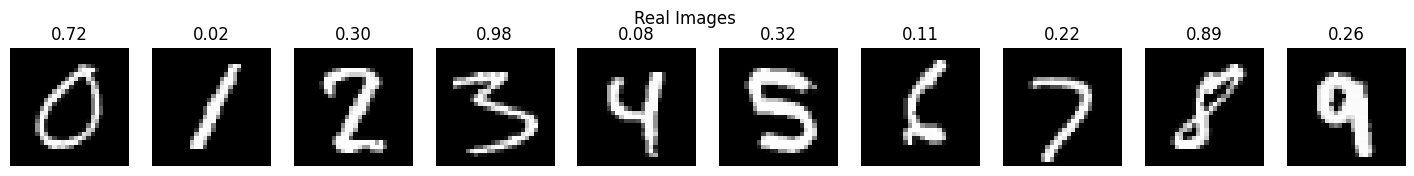

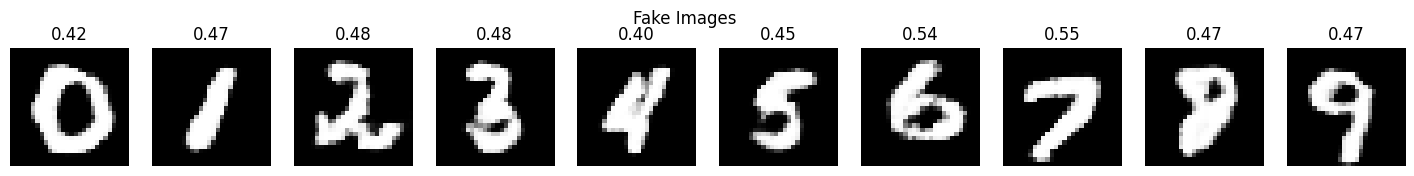

700/700 [==============================] - 60s 86ms/step - g_loss: 0.7198 - d_loss: 0.6848 - r_acc: 0.5075 - f_acc: 0.4893
Epoch 35/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7320 - d_loss: 0.6789 - r_acc: 0.5120 - f_acc: 0.4843

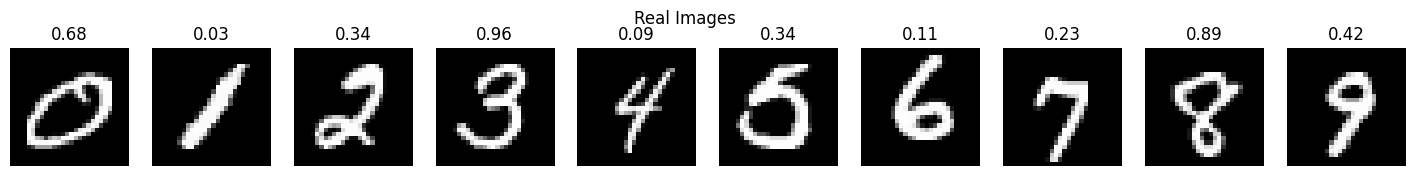

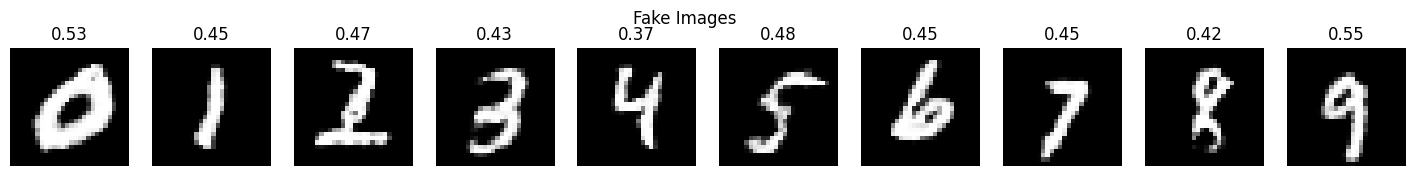

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7320 - d_loss: 0.6790 - r_acc: 0.5120 - f_acc: 0.4843
Epoch 36/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7252 - d_loss: 0.6832 - r_acc: 0.5093 - f_acc: 0.4874

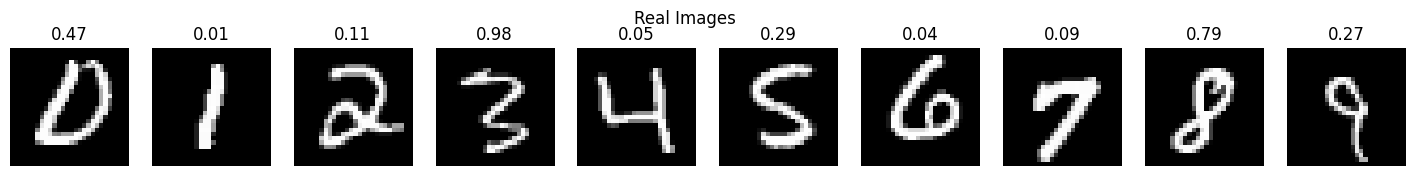

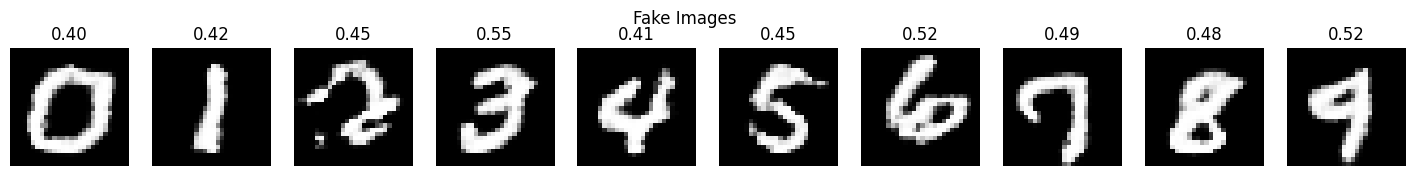

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7252 - d_loss: 0.6832 - r_acc: 0.5093 - f_acc: 0.4874
Epoch 37/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7332 - d_loss: 0.6764 - r_acc: 0.5132 - f_acc: 0.4837

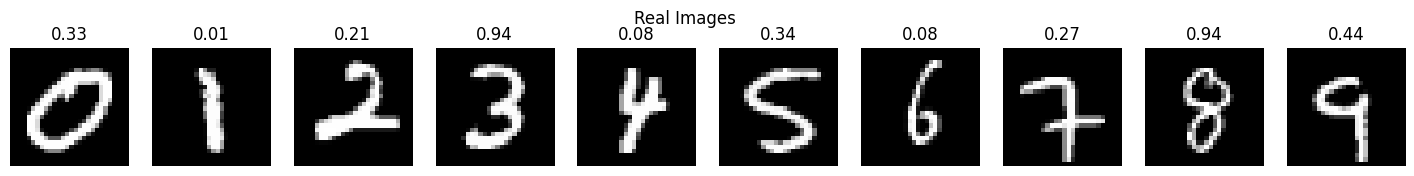

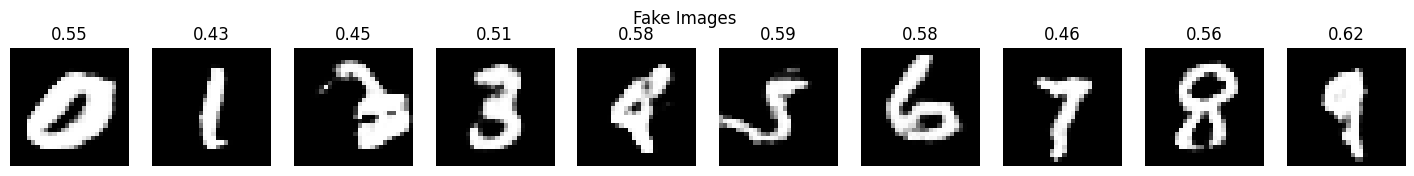

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7332 - d_loss: 0.6764 - r_acc: 0.5132 - f_acc: 0.4837
Epoch 38/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7445 - d_loss: 0.6709 - r_acc: 0.5170 - f_acc: 0.4793

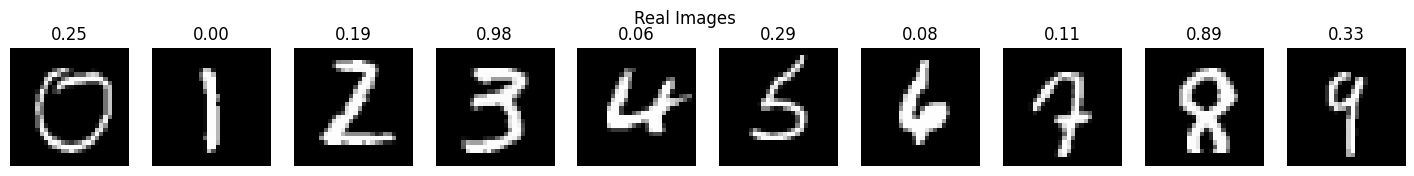

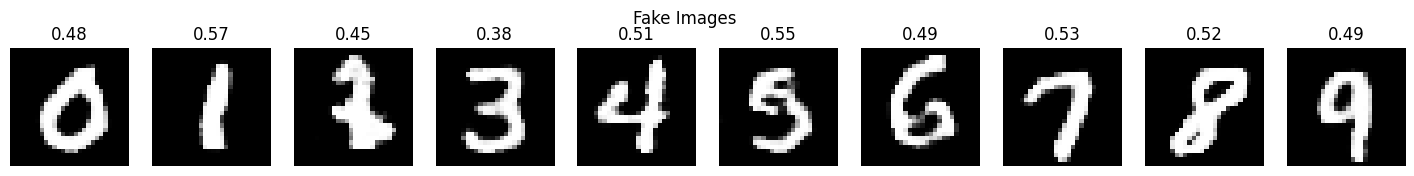

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7445 - d_loss: 0.6709 - r_acc: 0.5170 - f_acc: 0.4793
Epoch 39/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7421 - d_loss: 0.6748 - r_acc: 0.5147 - f_acc: 0.4805

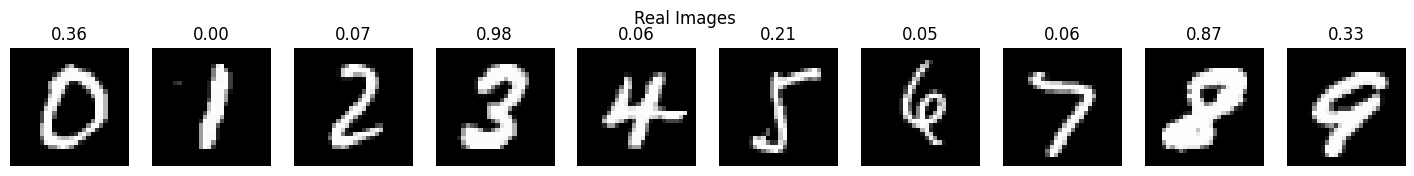

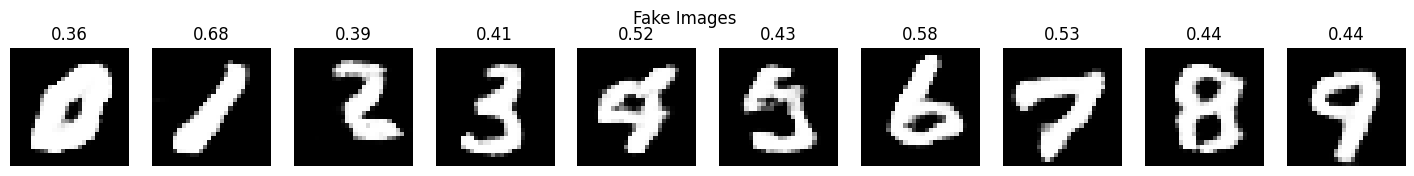

700/700 [==============================] - 58s 83ms/step - g_loss: 0.7421 - d_loss: 0.6748 - r_acc: 0.5147 - f_acc: 0.4805
Epoch 40/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7479 - d_loss: 0.6728 - r_acc: 0.5170 - f_acc: 0.4785

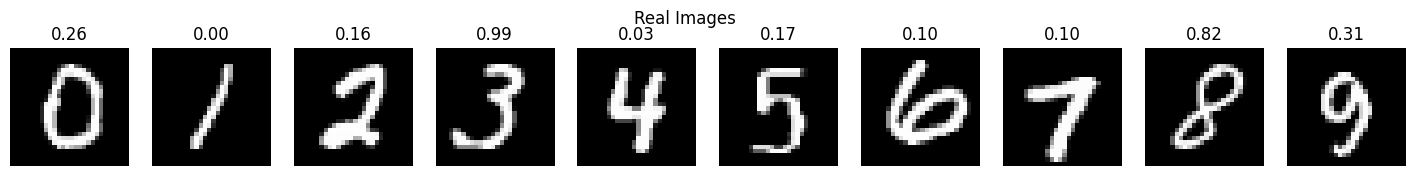

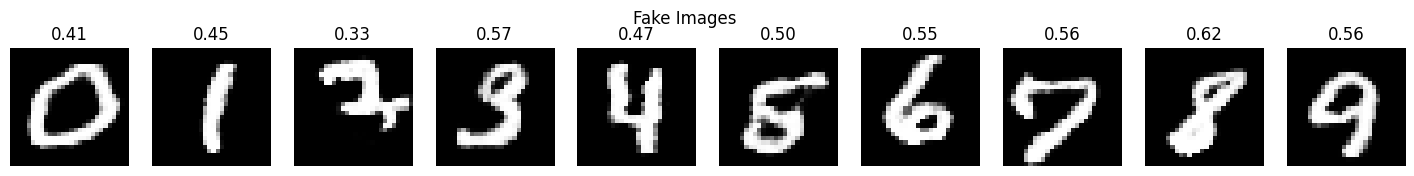

700/700 [==============================] - 59s 84ms/step - g_loss: 0.7479 - d_loss: 0.6728 - r_acc: 0.5170 - f_acc: 0.4785
Epoch 41/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7654 - d_loss: 0.6590 - r_acc: 0.5246 - f_acc: 0.4716

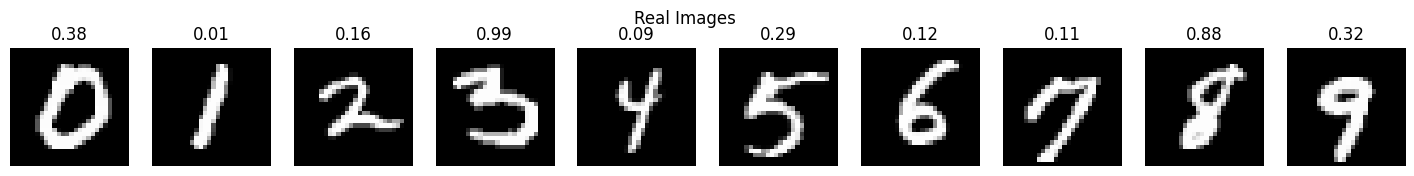

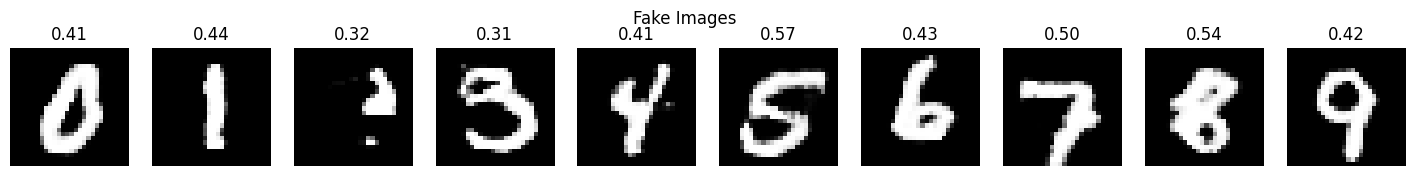

700/700 [==============================] - 58s 83ms/step - g_loss: 0.7654 - d_loss: 0.6590 - r_acc: 0.5246 - f_acc: 0.4716
Epoch 42/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7735 - d_loss: 0.6552 - r_acc: 0.5275 - f_acc: 0.4694

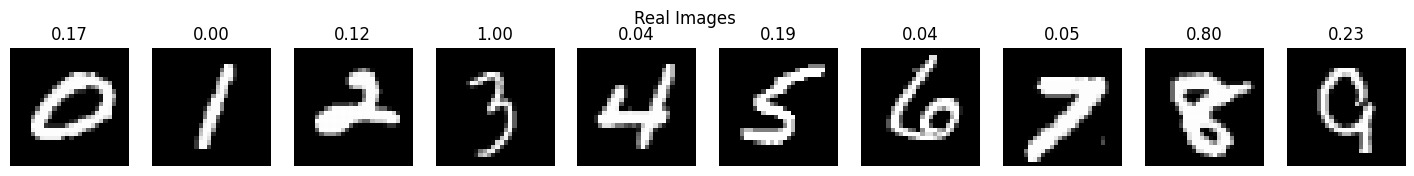

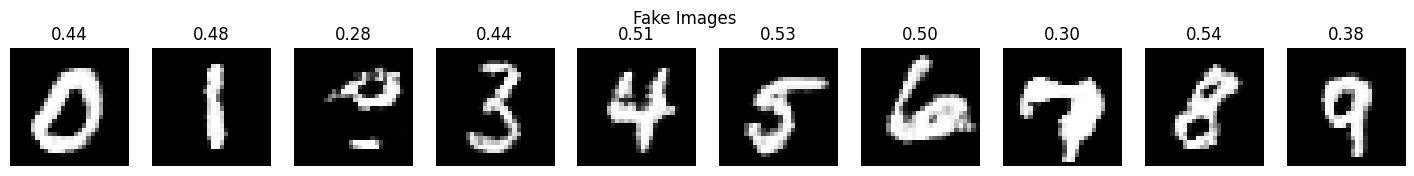

700/700 [==============================] - 58s 82ms/step - g_loss: 0.7735 - d_loss: 0.6552 - r_acc: 0.5275 - f_acc: 0.4694
Epoch 43/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7773 - d_loss: 0.6574 - r_acc: 0.5274 - f_acc: 0.4694

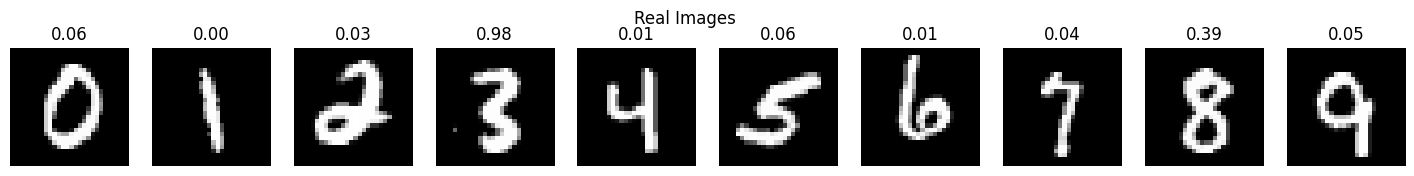

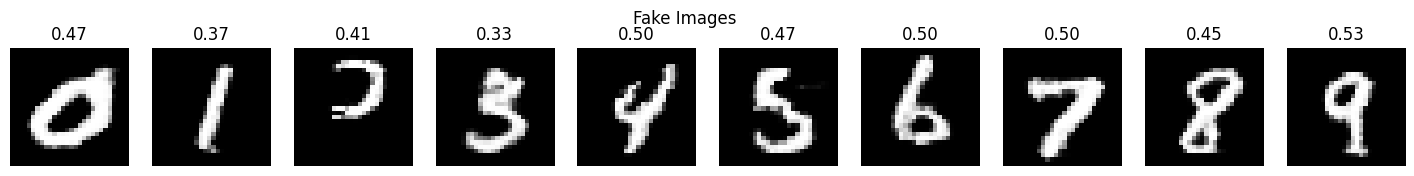

700/700 [==============================] - 57s 81ms/step - g_loss: 0.7773 - d_loss: 0.6574 - r_acc: 0.5274 - f_acc: 0.4694
Epoch 44/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7724 - d_loss: 0.6599 - r_acc: 0.5259 - f_acc: 0.4710

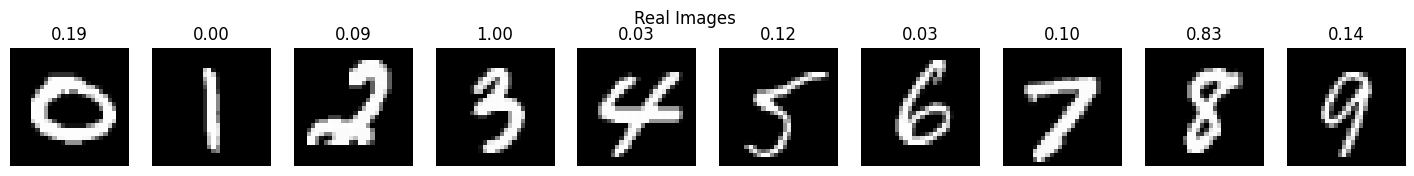

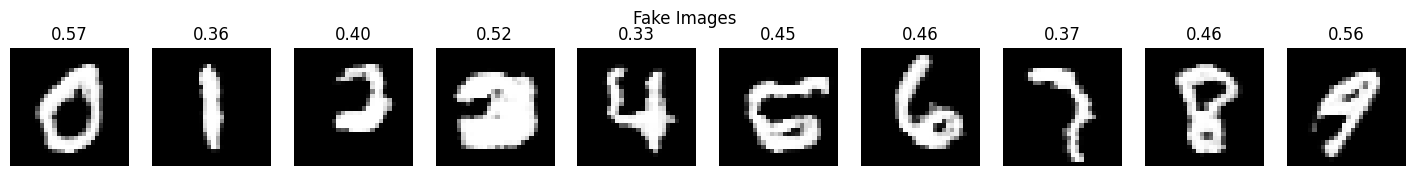

700/700 [==============================] - 57s 81ms/step - g_loss: 0.7724 - d_loss: 0.6599 - r_acc: 0.5259 - f_acc: 0.4710
Epoch 45/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7562 - d_loss: 0.6669 - r_acc: 0.5212 - f_acc: 0.4763

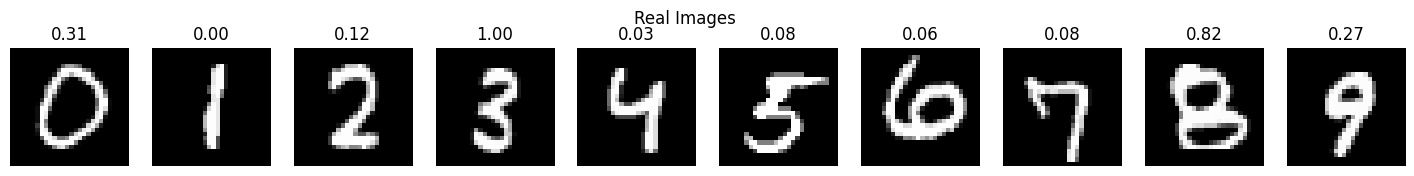

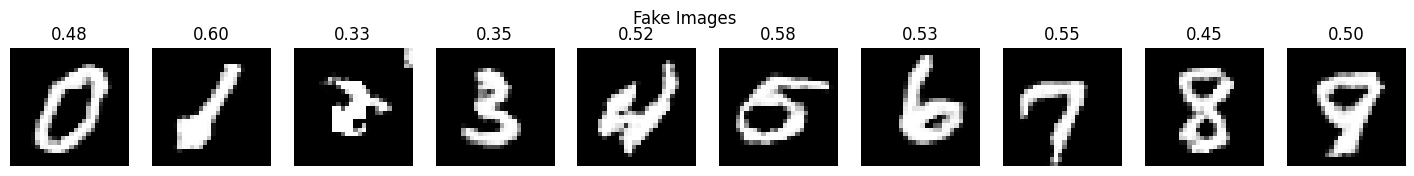

700/700 [==============================] - 58s 82ms/step - g_loss: 0.7562 - d_loss: 0.6669 - r_acc: 0.5212 - f_acc: 0.4763
Epoch 46/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7760 - d_loss: 0.6583 - r_acc: 0.5268 - f_acc: 0.4700

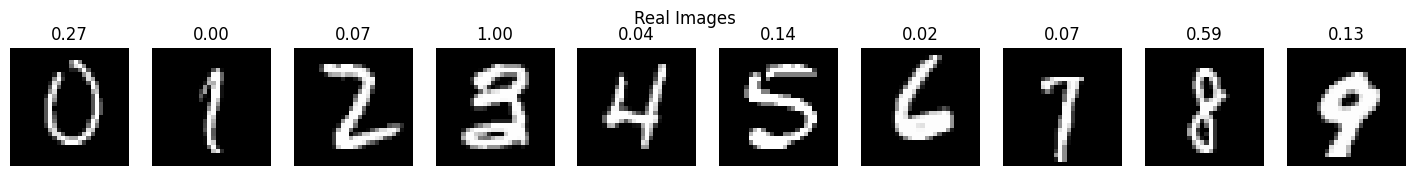

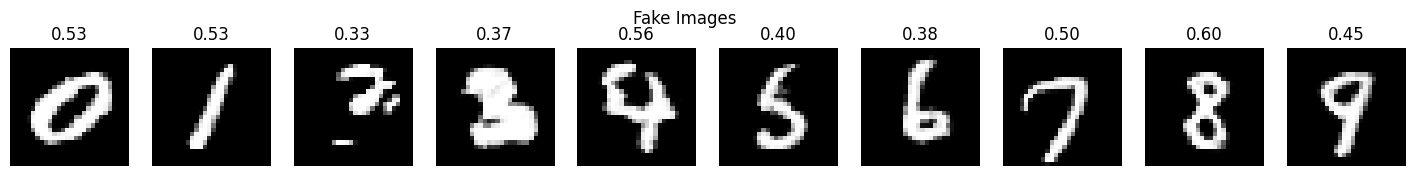

700/700 [==============================] - 56s 80ms/step - g_loss: 0.7761 - d_loss: 0.6583 - r_acc: 0.5268 - f_acc: 0.4700
Epoch 47/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7961 - d_loss: 0.6490 - r_acc: 0.5333 - f_acc: 0.4644

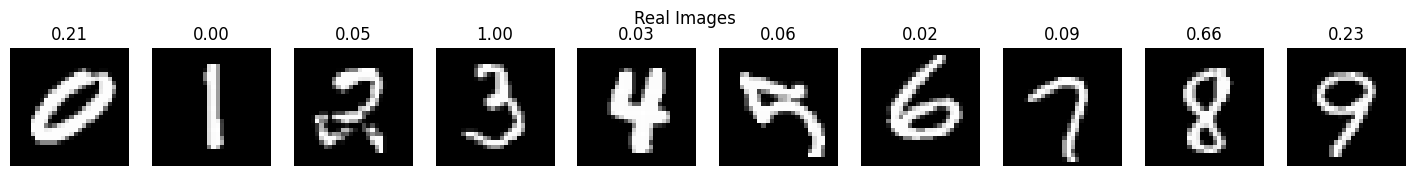

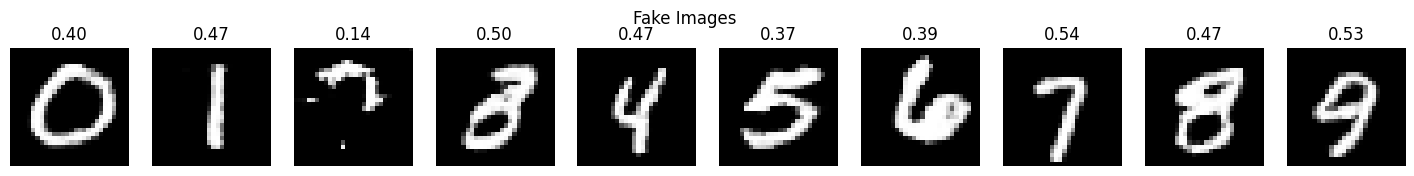

700/700 [==============================] - 57s 82ms/step - g_loss: 0.7961 - d_loss: 0.6490 - r_acc: 0.5333 - f_acc: 0.4644
Epoch 48/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8065 - d_loss: 0.6448 - r_acc: 0.5362 - f_acc: 0.4620

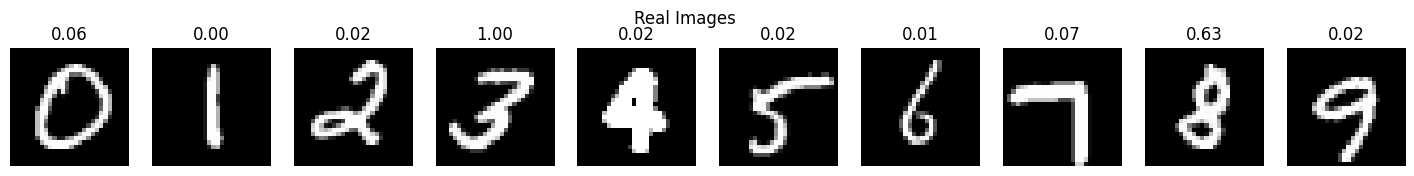

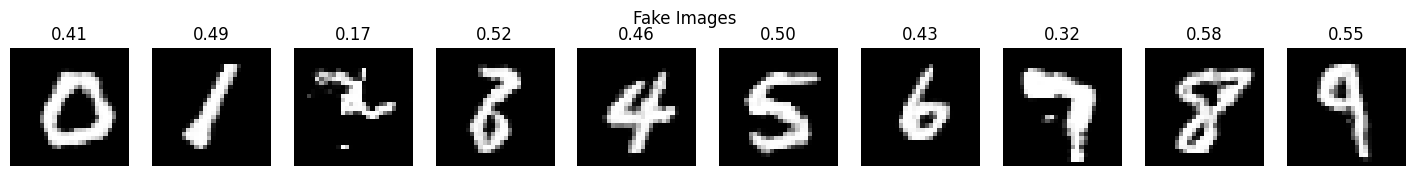

700/700 [==============================] - 56s 80ms/step - g_loss: 0.8065 - d_loss: 0.6448 - r_acc: 0.5362 - f_acc: 0.4620
Epoch 49/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8113 - d_loss: 0.6455 - r_acc: 0.5370 - f_acc: 0.4620

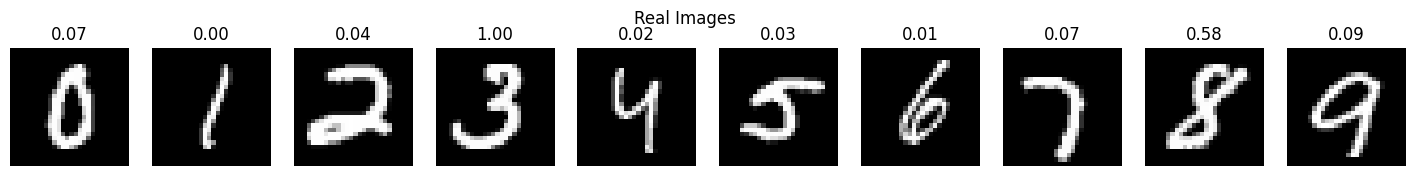

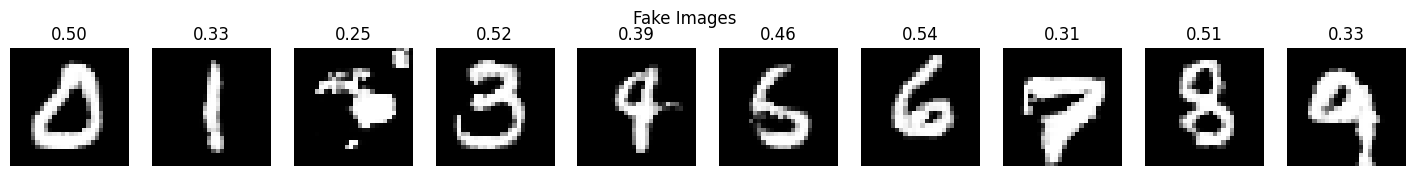

700/700 [==============================] - 58s 83ms/step - g_loss: 0.8113 - d_loss: 0.6455 - r_acc: 0.5370 - f_acc: 0.4620
Epoch 50/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7879 - d_loss: 0.6576 - r_acc: 0.5300 - f_acc: 0.4681

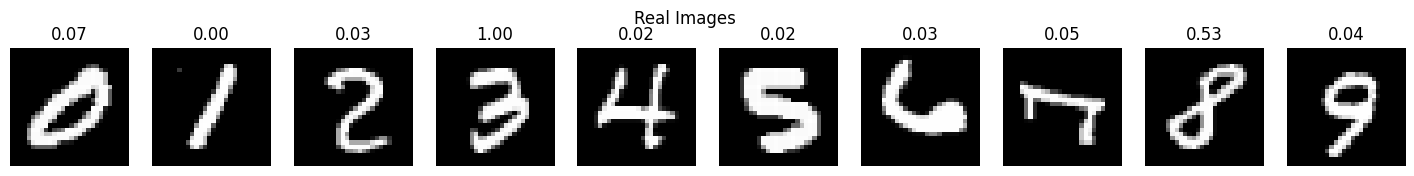

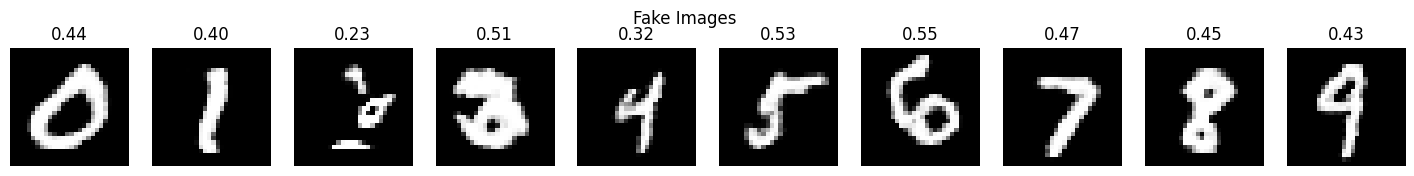

700/700 [==============================] - 56s 81ms/step - g_loss: 0.7879 - d_loss: 0.6576 - r_acc: 0.5300 - f_acc: 0.4681
Epoch 51/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7849 - d_loss: 0.6609 - r_acc: 0.5283 - f_acc: 0.4694

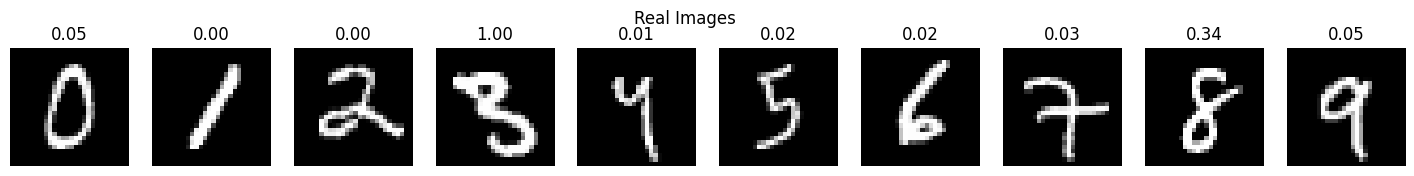

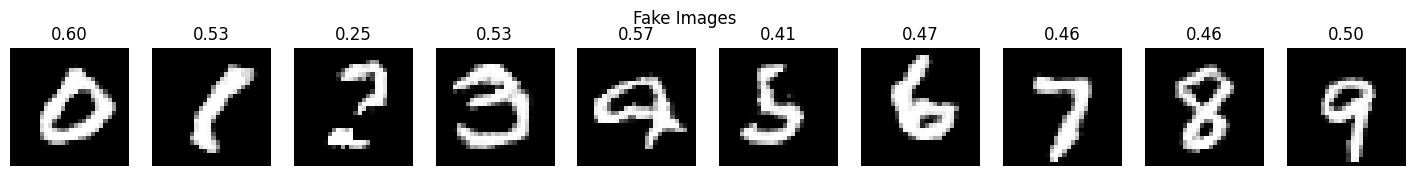

700/700 [==============================] - 57s 82ms/step - g_loss: 0.7849 - d_loss: 0.6609 - r_acc: 0.5282 - f_acc: 0.4694
Epoch 52/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7712 - d_loss: 0.6654 - r_acc: 0.5247 - f_acc: 0.4732

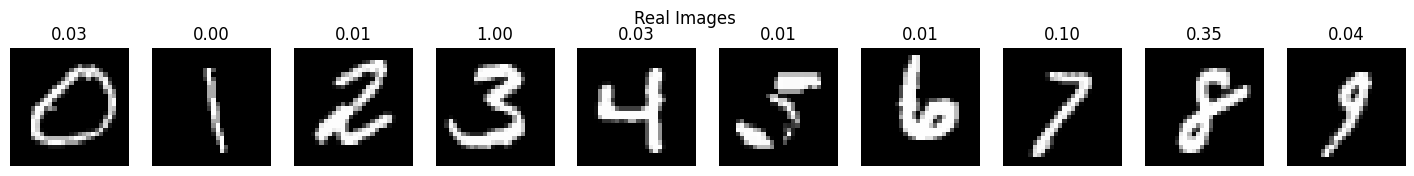

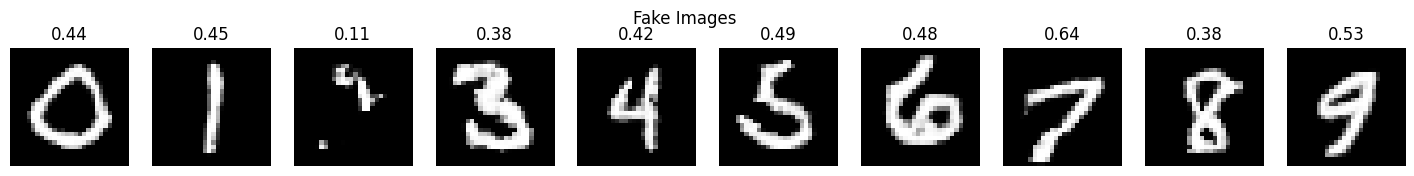

700/700 [==============================] - 57s 82ms/step - g_loss: 0.7713 - d_loss: 0.6654 - r_acc: 0.5247 - f_acc: 0.4732
Epoch 53/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8326 - d_loss: 0.6439 - r_acc: 0.5398 - f_acc: 0.4593

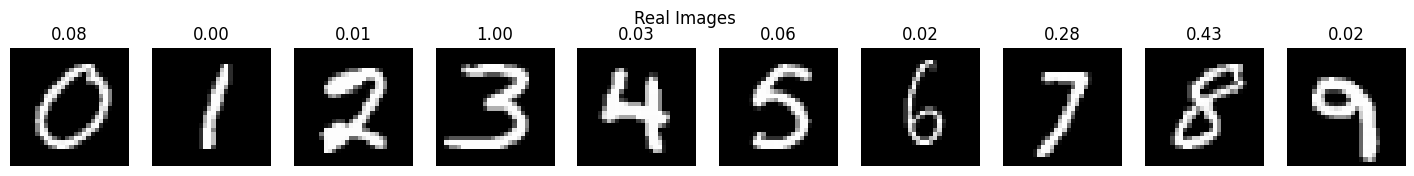

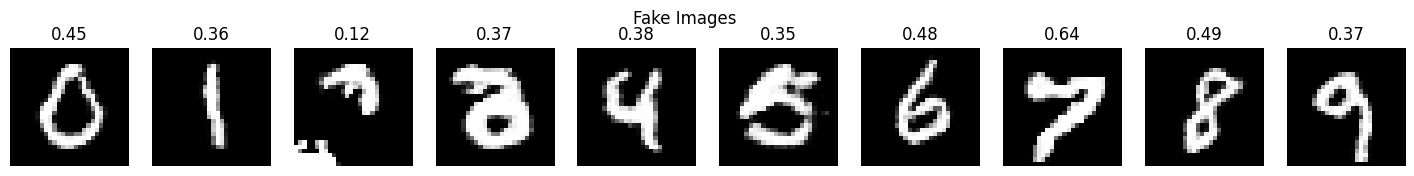

700/700 [==============================] - 56s 80ms/step - g_loss: 0.8326 - d_loss: 0.6439 - r_acc: 0.5398 - f_acc: 0.4593
Epoch 54/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7993 - d_loss: 0.6558 - r_acc: 0.5312 - f_acc: 0.4673

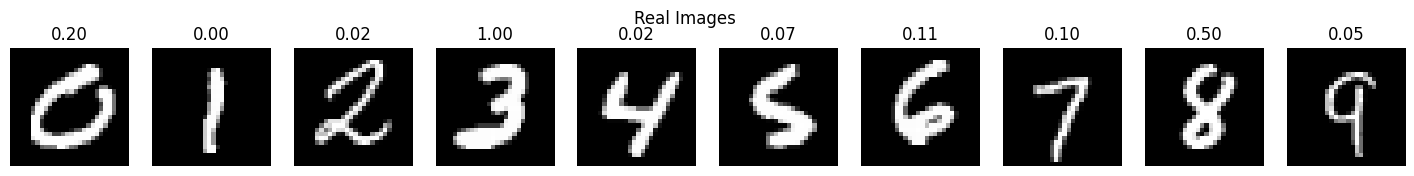

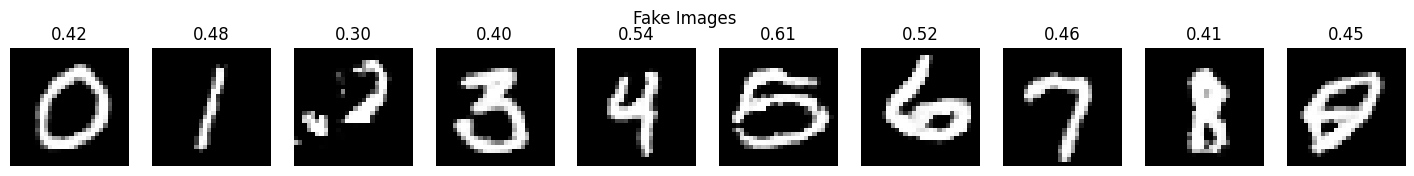

700/700 [==============================] - 57s 81ms/step - g_loss: 0.7992 - d_loss: 0.6558 - r_acc: 0.5312 - f_acc: 0.4673
Epoch 55/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7701 - d_loss: 0.6649 - r_acc: 0.5250 - f_acc: 0.4740

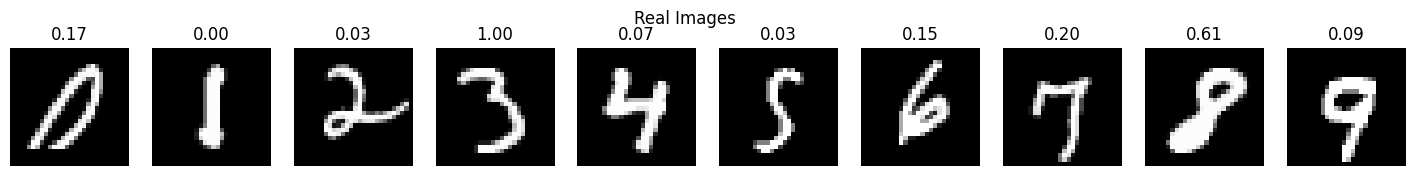

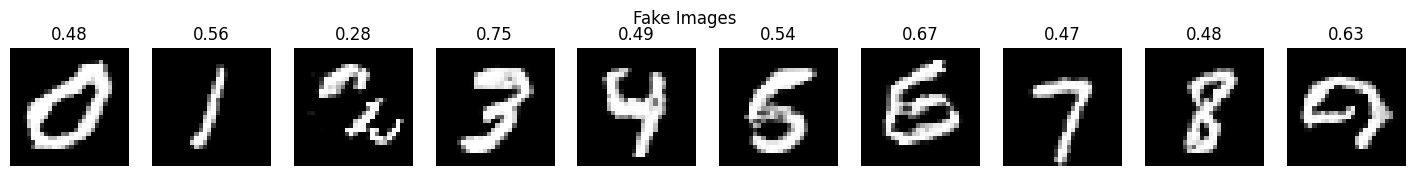

700/700 [==============================] - 55s 79ms/step - g_loss: 0.7701 - d_loss: 0.6649 - r_acc: 0.5250 - f_acc: 0.4740
Epoch 56/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7667 - d_loss: 0.6700 - r_acc: 0.5220 - f_acc: 0.4750

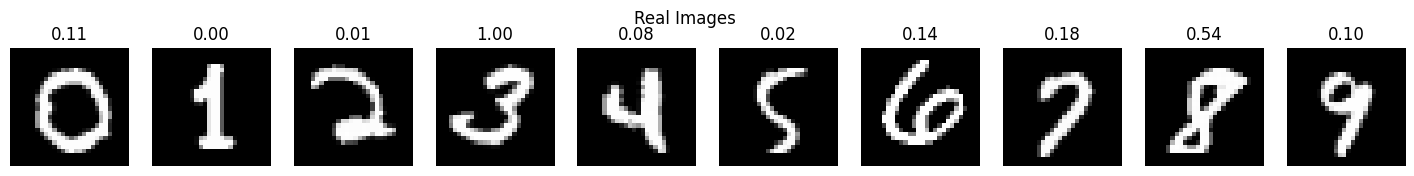

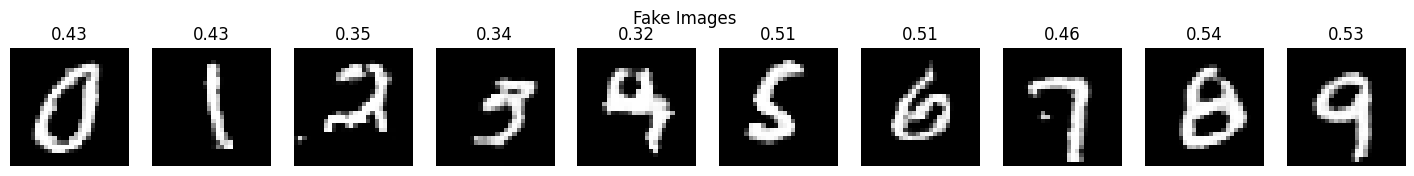

700/700 [==============================] - 57s 81ms/step - g_loss: 0.7667 - d_loss: 0.6700 - r_acc: 0.5220 - f_acc: 0.4751
Epoch 57/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7602 - d_loss: 0.6711 - r_acc: 0.5209 - f_acc: 0.4770

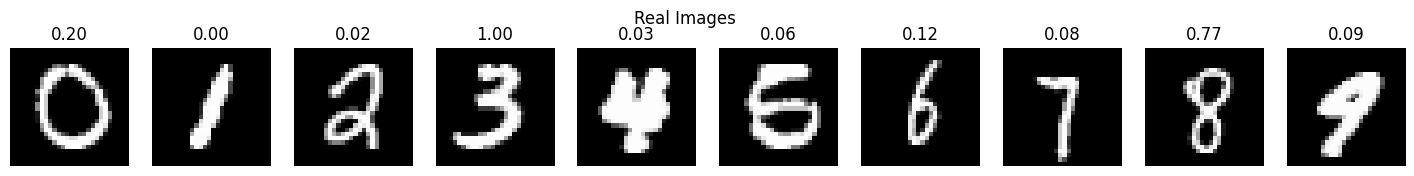

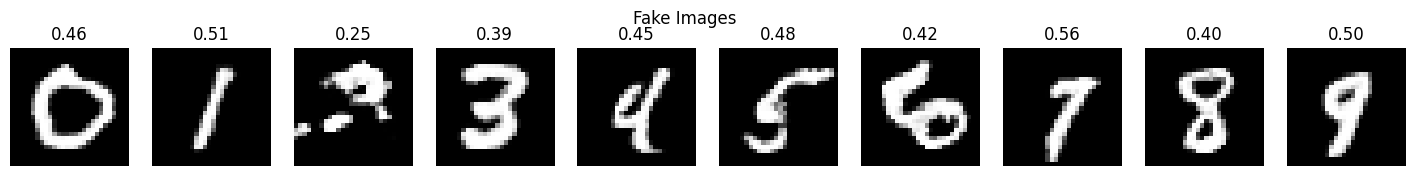

700/700 [==============================] - 56s 80ms/step - g_loss: 0.7602 - d_loss: 0.6711 - r_acc: 0.5209 - f_acc: 0.4770
Epoch 58/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7730 - d_loss: 0.6647 - r_acc: 0.5251 - f_acc: 0.4735

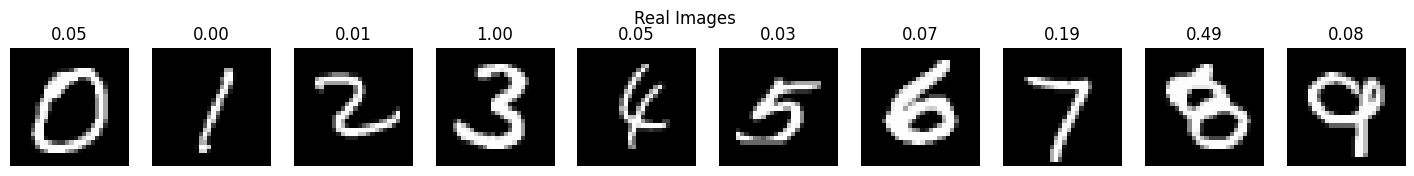

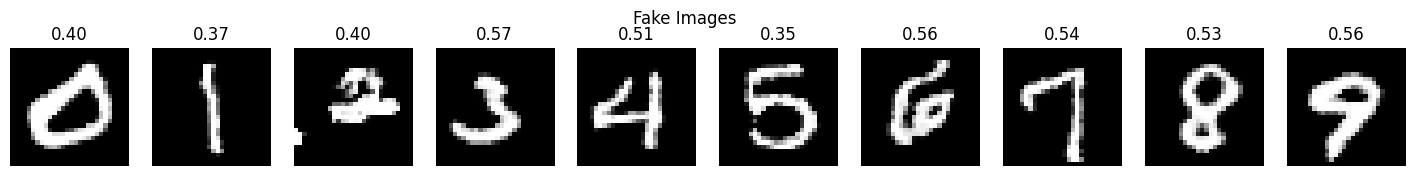

700/700 [==============================] - 55s 79ms/step - g_loss: 0.7730 - d_loss: 0.6647 - r_acc: 0.5251 - f_acc: 0.4735
Epoch 59/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7727 - d_loss: 0.6656 - r_acc: 0.5248 - f_acc: 0.4741

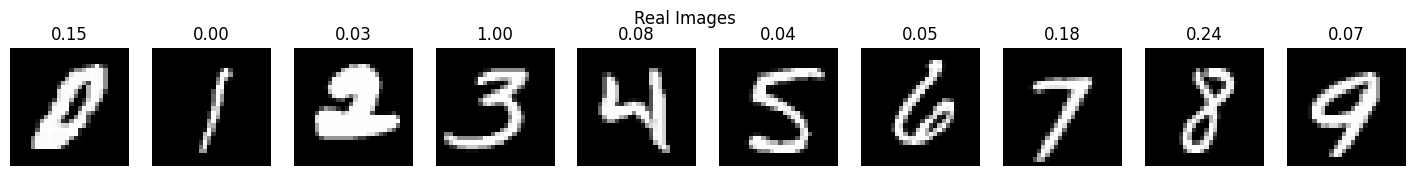

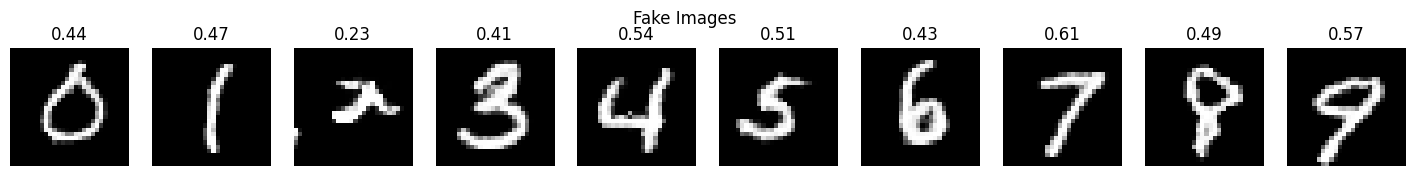

700/700 [==============================] - 56s 80ms/step - g_loss: 0.7727 - d_loss: 0.6656 - r_acc: 0.5248 - f_acc: 0.4741
Epoch 60/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7905 - d_loss: 0.6590 - r_acc: 0.5292 - f_acc: 0.4689

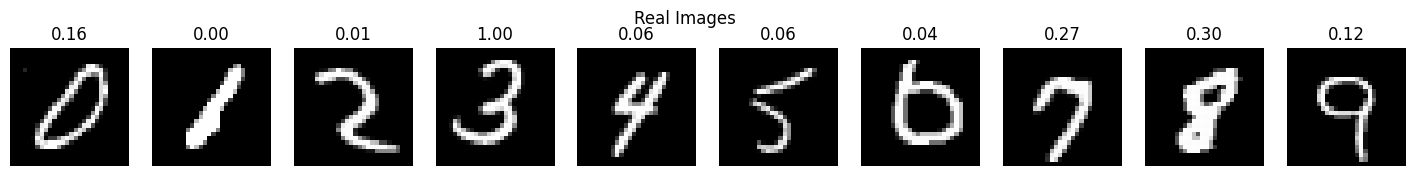

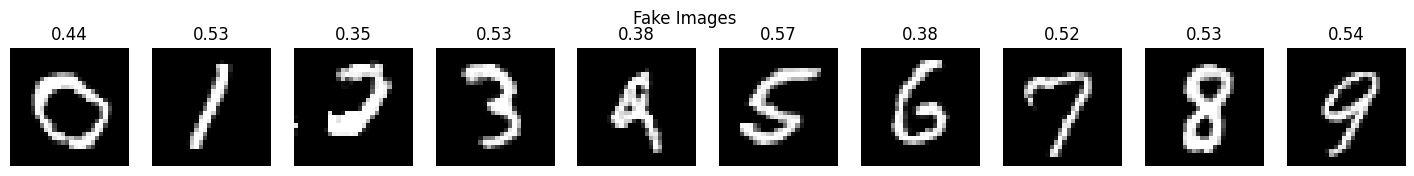

700/700 [==============================] - 54s 78ms/step - g_loss: 0.7905 - d_loss: 0.6590 - r_acc: 0.5292 - f_acc: 0.4689
Epoch 61/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7621 - d_loss: 0.6721 - r_acc: 0.5207 - f_acc: 0.4773

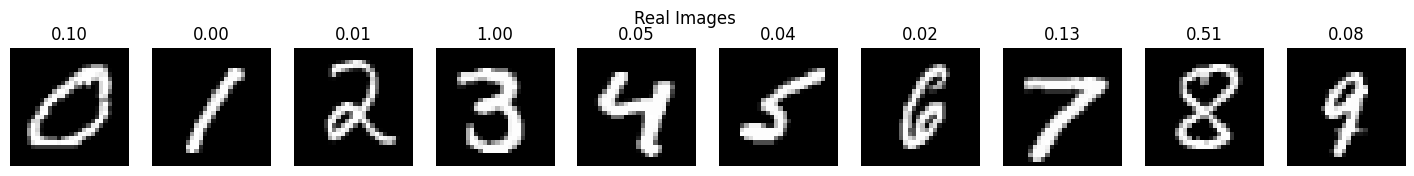

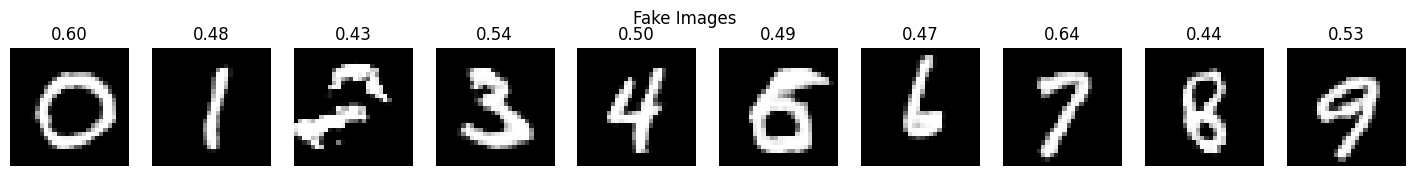

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7621 - d_loss: 0.6721 - r_acc: 0.5207 - f_acc: 0.4773
Epoch 62/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7829 - d_loss: 0.6643 - r_acc: 0.5266 - f_acc: 0.4717

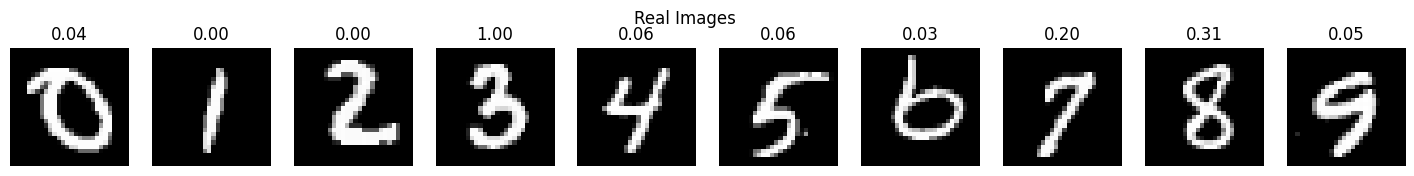

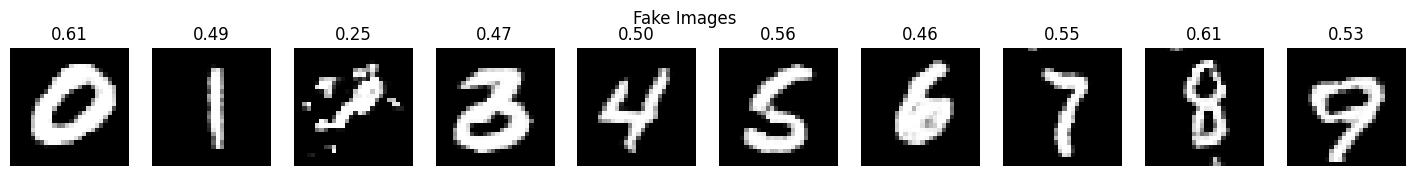

700/700 [==============================] - 62s 89ms/step - g_loss: 0.7829 - d_loss: 0.6643 - r_acc: 0.5266 - f_acc: 0.4717
Epoch 63/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7822 - d_loss: 0.6630 - r_acc: 0.5268 - f_acc: 0.4712

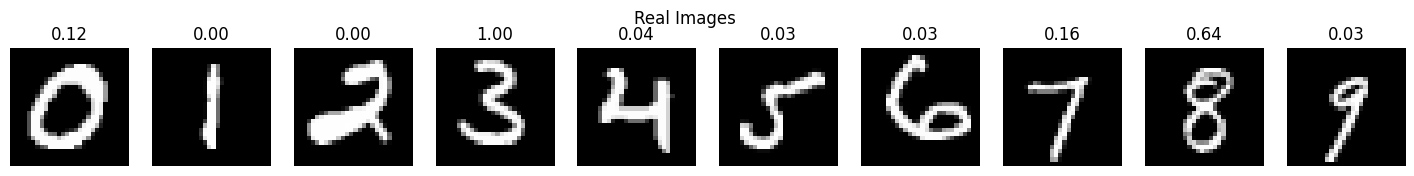

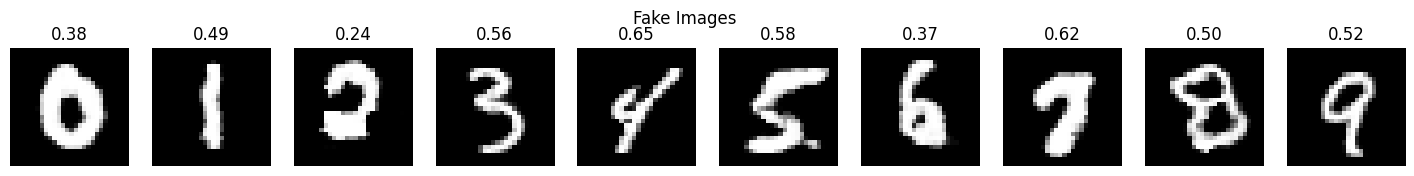

700/700 [==============================] - 59s 84ms/step - g_loss: 0.7822 - d_loss: 0.6630 - r_acc: 0.5268 - f_acc: 0.4712
Epoch 64/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7756 - d_loss: 0.6680 - r_acc: 0.5240 - f_acc: 0.4735

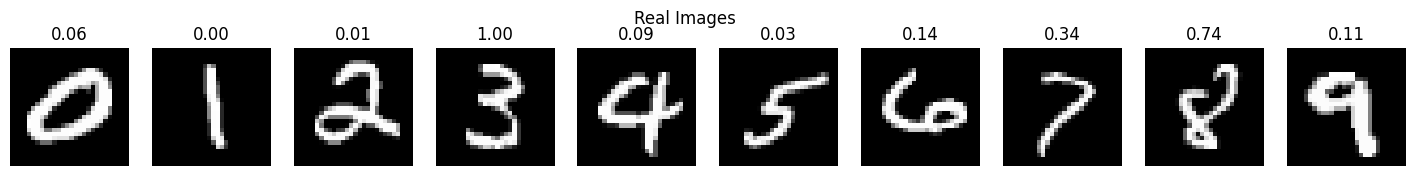

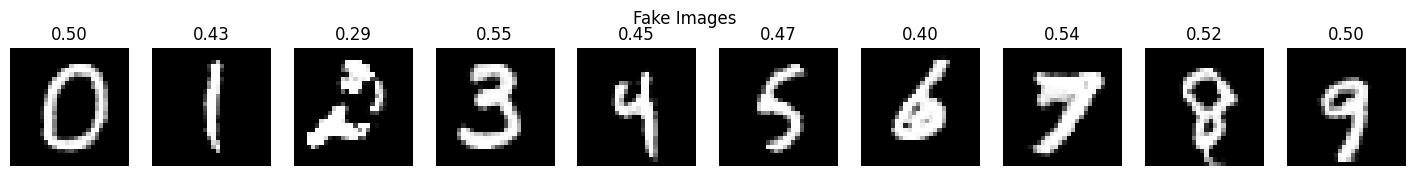

700/700 [==============================] - 57s 82ms/step - g_loss: 0.7756 - d_loss: 0.6680 - r_acc: 0.5240 - f_acc: 0.4735
Epoch 65/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7765 - d_loss: 0.6658 - r_acc: 0.5253 - f_acc: 0.4727

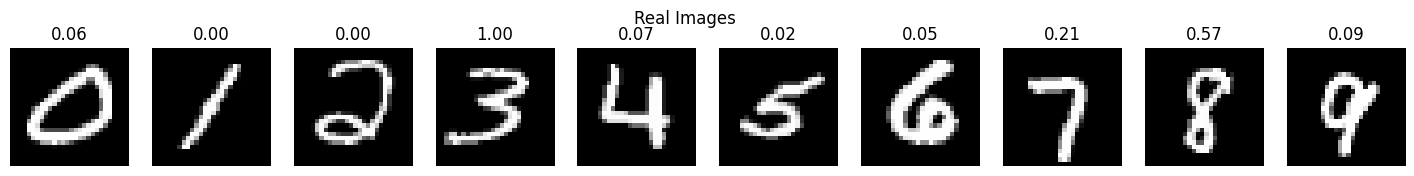

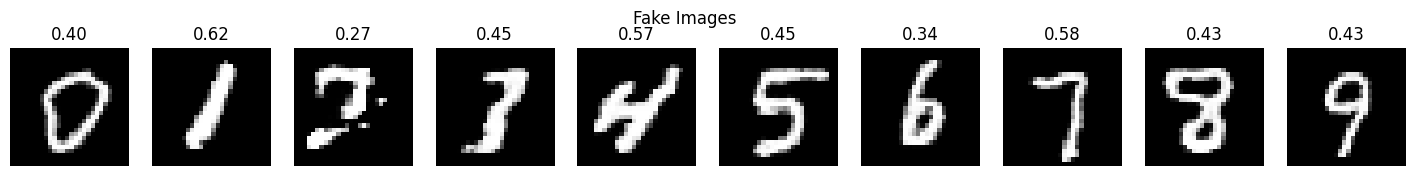

700/700 [==============================] - 55s 79ms/step - g_loss: 0.7765 - d_loss: 0.6658 - r_acc: 0.5253 - f_acc: 0.4727
Epoch 66/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8106 - d_loss: 0.6533 - r_acc: 0.5338 - f_acc: 0.4646

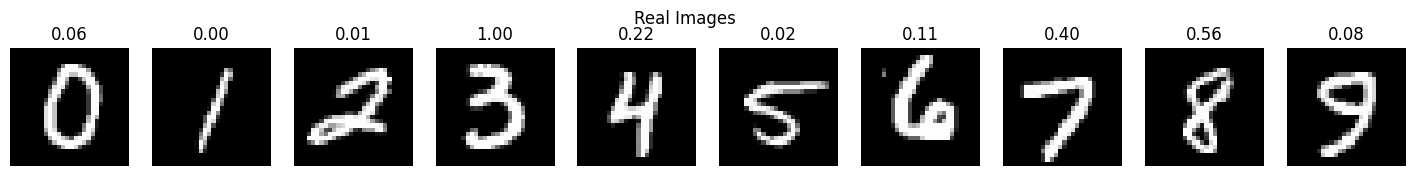

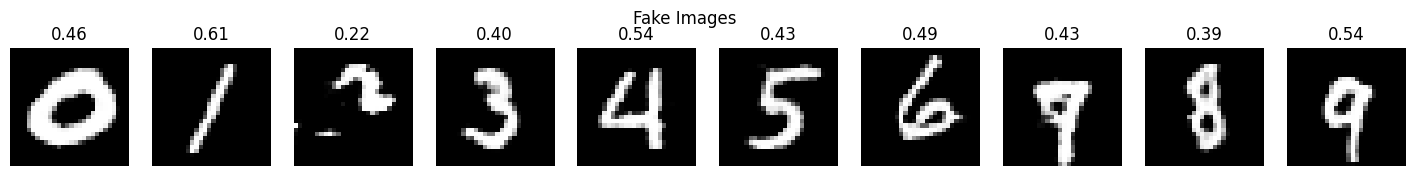

700/700 [==============================] - 57s 81ms/step - g_loss: 0.8106 - d_loss: 0.6533 - r_acc: 0.5338 - f_acc: 0.4646
Epoch 67/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8222 - d_loss: 0.6502 - r_acc: 0.5356 - f_acc: 0.4635

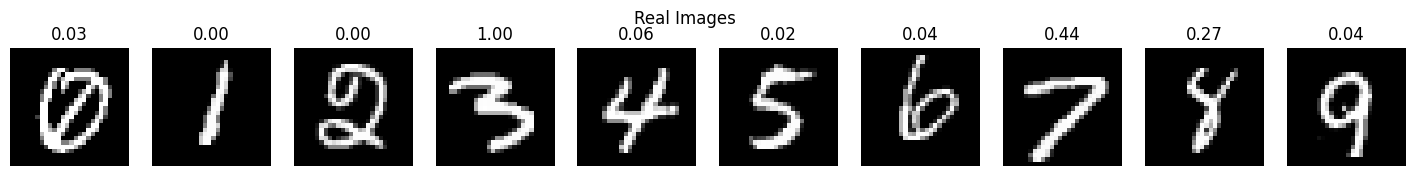

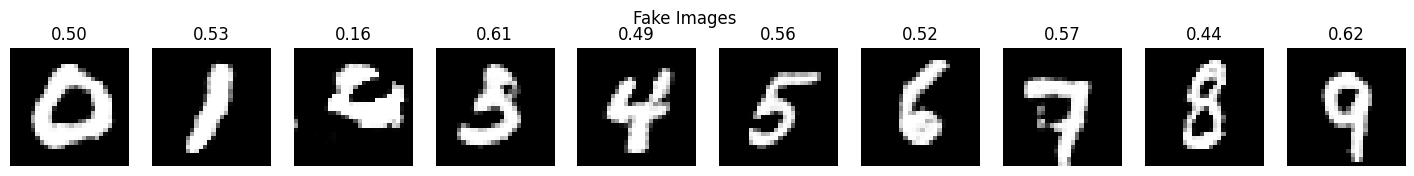

700/700 [==============================] - 55s 79ms/step - g_loss: 0.8222 - d_loss: 0.6502 - r_acc: 0.5356 - f_acc: 0.4635
Epoch 68/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7964 - d_loss: 0.6592 - r_acc: 0.5297 - f_acc: 0.4676

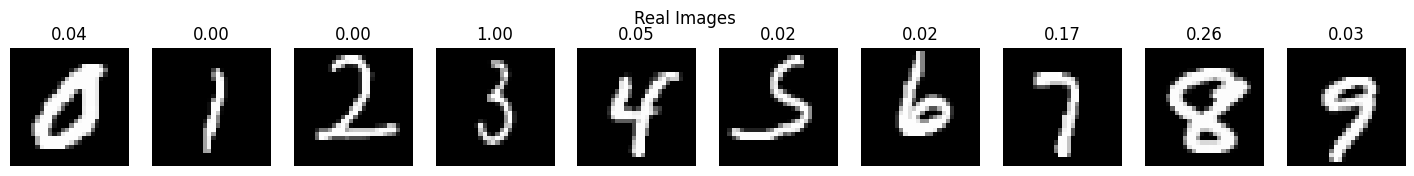

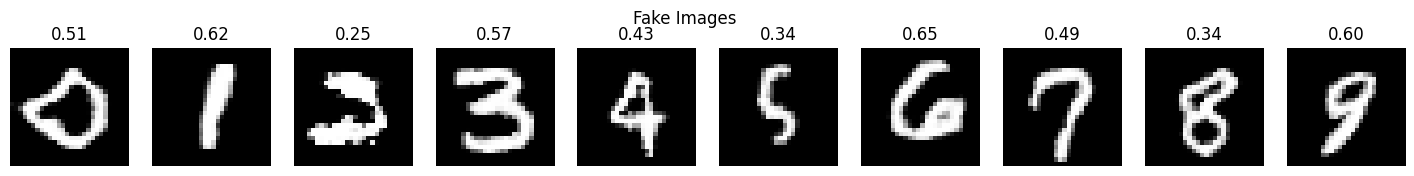

700/700 [==============================] - 55s 79ms/step - g_loss: 0.7964 - d_loss: 0.6592 - r_acc: 0.5297 - f_acc: 0.4676
Epoch 69/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7828 - d_loss: 0.6665 - r_acc: 0.5256 - f_acc: 0.4721

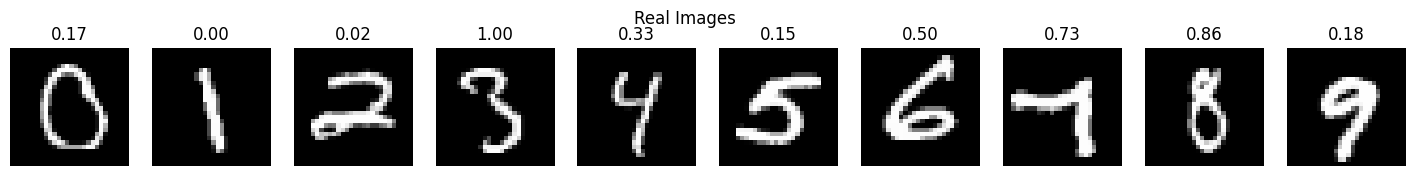

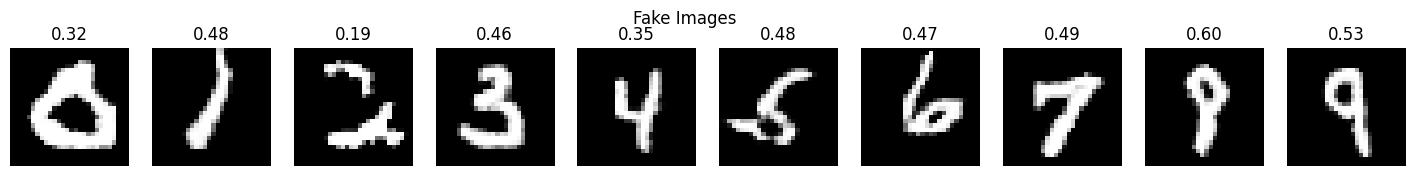

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7829 - d_loss: 0.6665 - r_acc: 0.5256 - f_acc: 0.4721
Epoch 70/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7927 - d_loss: 0.6600 - r_acc: 0.5289 - f_acc: 0.4693

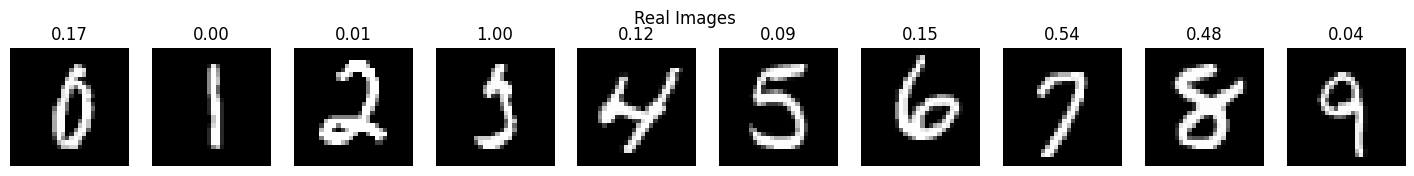

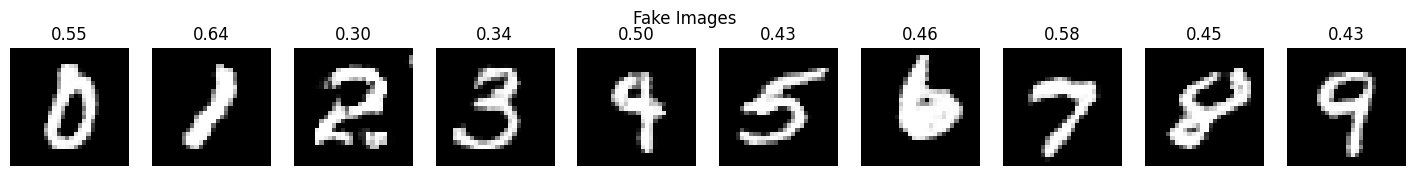

700/700 [==============================] - 54s 78ms/step - g_loss: 0.7927 - d_loss: 0.6600 - r_acc: 0.5288 - f_acc: 0.4693
Epoch 71/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7590 - d_loss: 0.6739 - r_acc: 0.5189 - f_acc: 0.4782

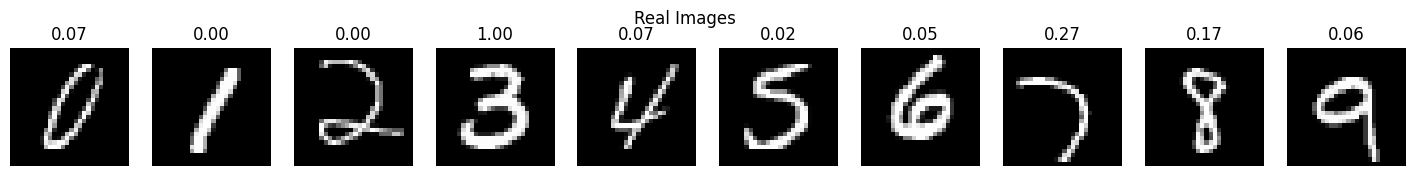

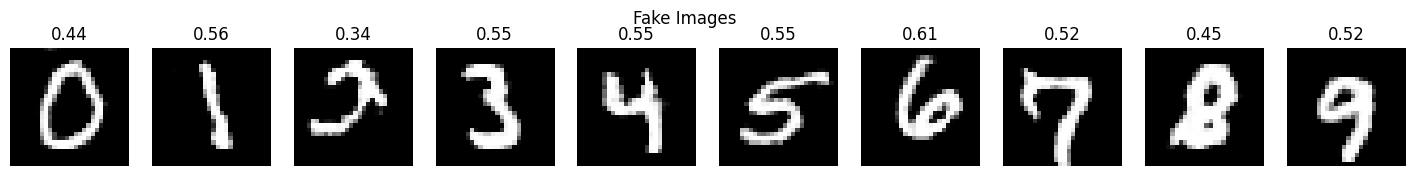

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7590 - d_loss: 0.6739 - r_acc: 0.5190 - f_acc: 0.4782
Epoch 72/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7876 - d_loss: 0.6615 - r_acc: 0.5277 - f_acc: 0.4709

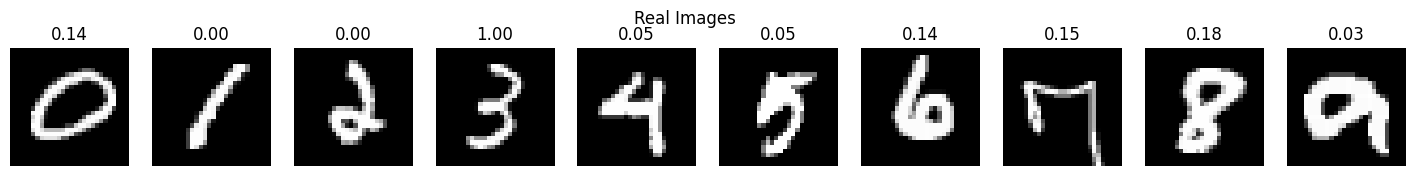

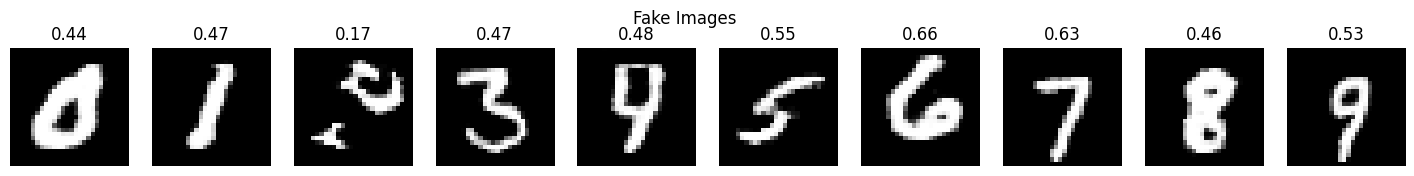

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7877 - d_loss: 0.6615 - r_acc: 0.5277 - f_acc: 0.4709
Epoch 73/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8073 - d_loss: 0.6564 - r_acc: 0.5319 - f_acc: 0.4658

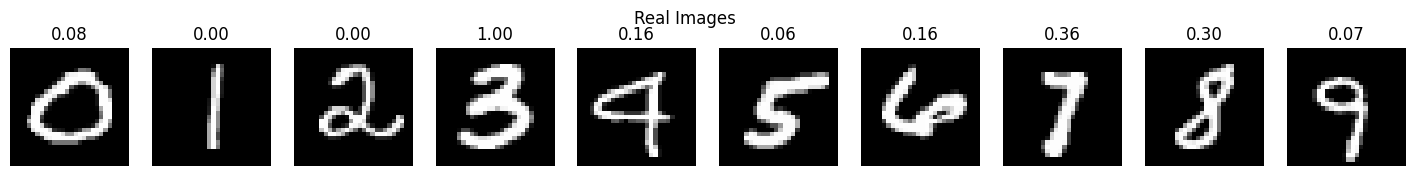

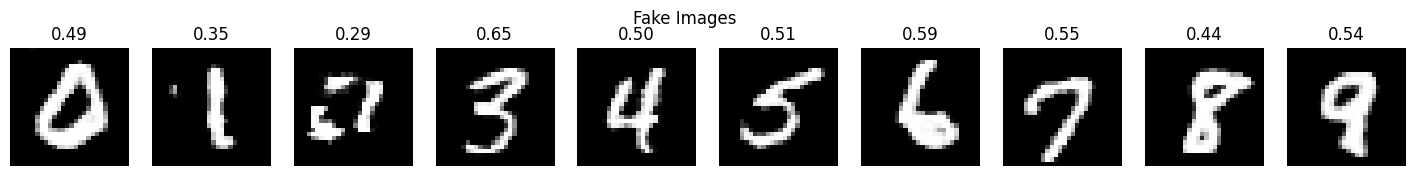

700/700 [==============================] - 55s 79ms/step - g_loss: 0.8073 - d_loss: 0.6564 - r_acc: 0.5319 - f_acc: 0.4658
Epoch 74/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7885 - d_loss: 0.6627 - r_acc: 0.5272 - f_acc: 0.4709

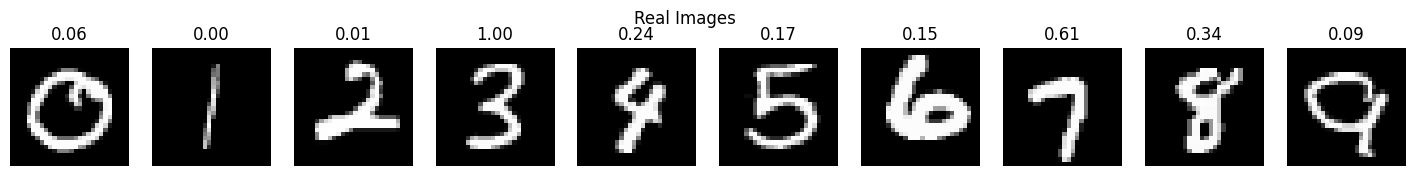

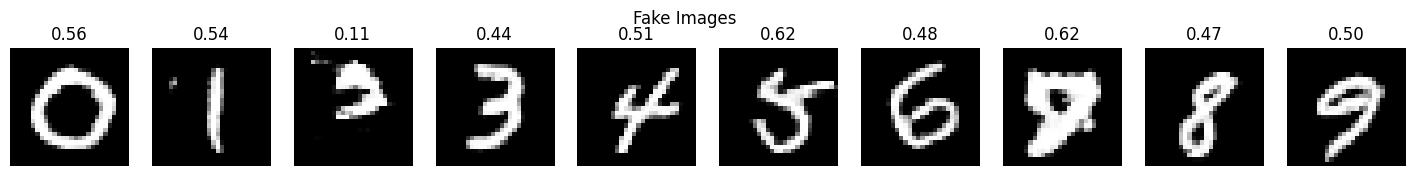

700/700 [==============================] - 55s 78ms/step - g_loss: 0.7885 - d_loss: 0.6627 - r_acc: 0.5272 - f_acc: 0.4709
Epoch 75/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8192 - d_loss: 0.6512 - r_acc: 0.5348 - f_acc: 0.4643

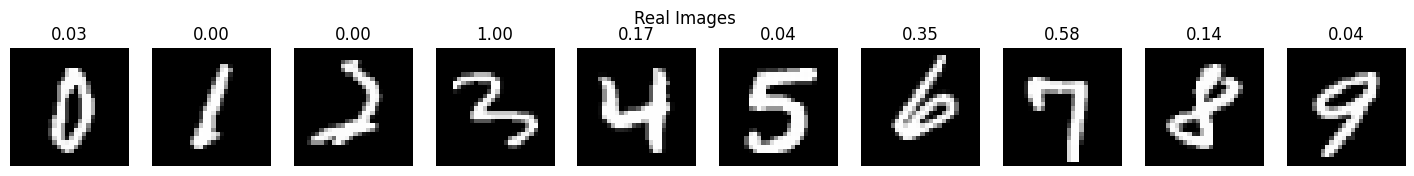

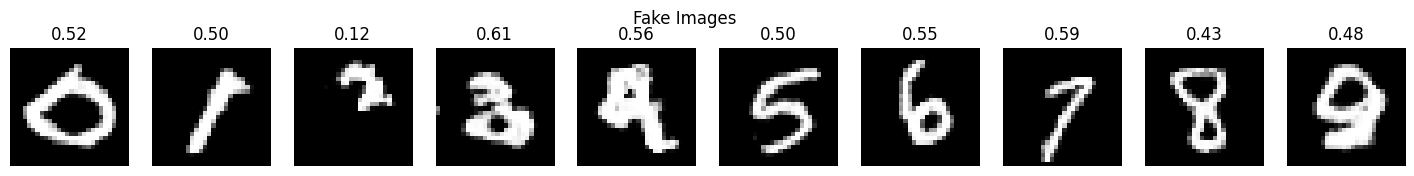

700/700 [==============================] - 55s 79ms/step - g_loss: 0.8192 - d_loss: 0.6512 - r_acc: 0.5348 - f_acc: 0.4643
Epoch 76/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8520 - d_loss: 0.6431 - r_acc: 0.5409 - f_acc: 0.4586

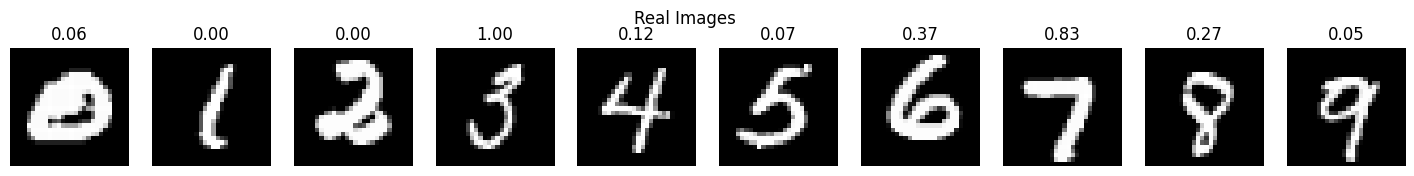

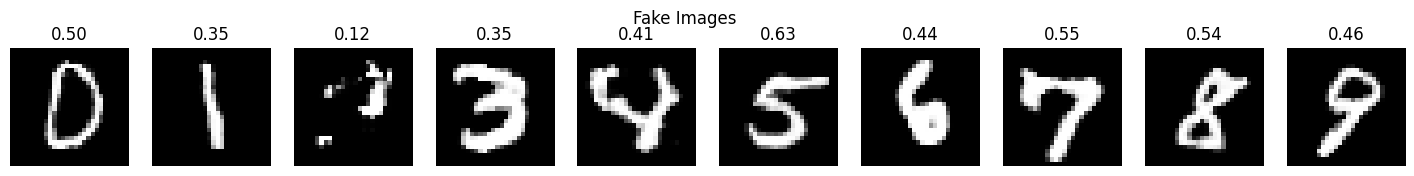

700/700 [==============================] - 54s 78ms/step - g_loss: 0.8520 - d_loss: 0.6431 - r_acc: 0.5409 - f_acc: 0.4586
Epoch 77/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7809 - d_loss: 0.6623 - r_acc: 0.5267 - f_acc: 0.4713

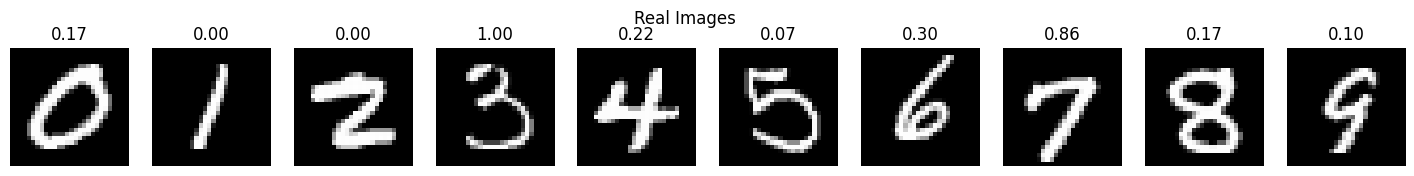

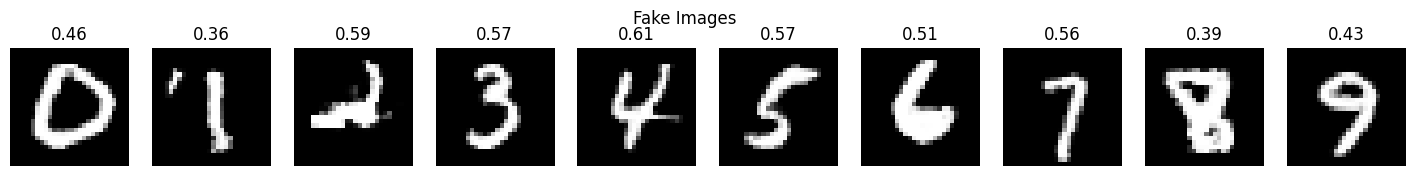

700/700 [==============================] - 54s 78ms/step - g_loss: 0.7809 - d_loss: 0.6623 - r_acc: 0.5267 - f_acc: 0.4713
Epoch 78/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7517 - d_loss: 0.6798 - r_acc: 0.5166 - f_acc: 0.4811

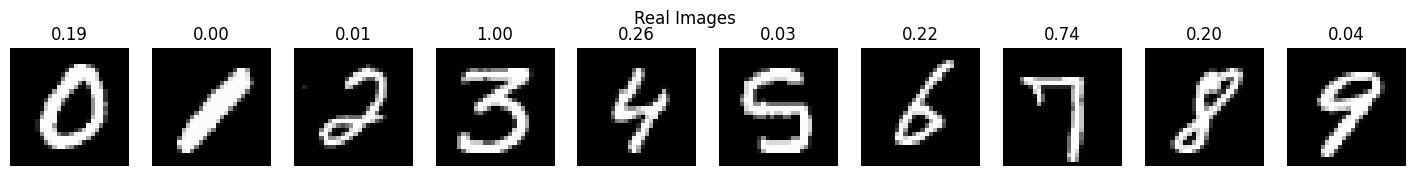

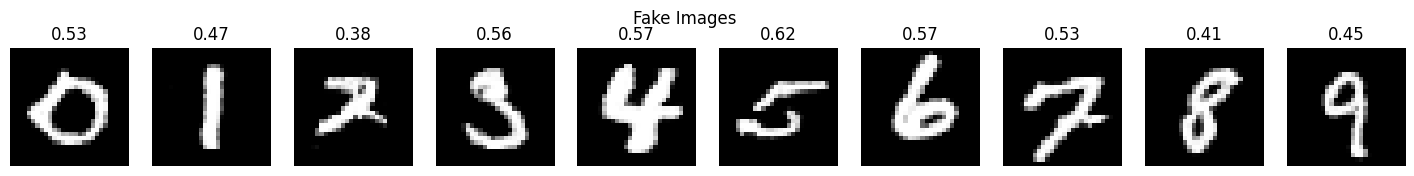

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7517 - d_loss: 0.6798 - r_acc: 0.5166 - f_acc: 0.4811
Epoch 79/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7497 - d_loss: 0.6793 - r_acc: 0.5162 - f_acc: 0.4815

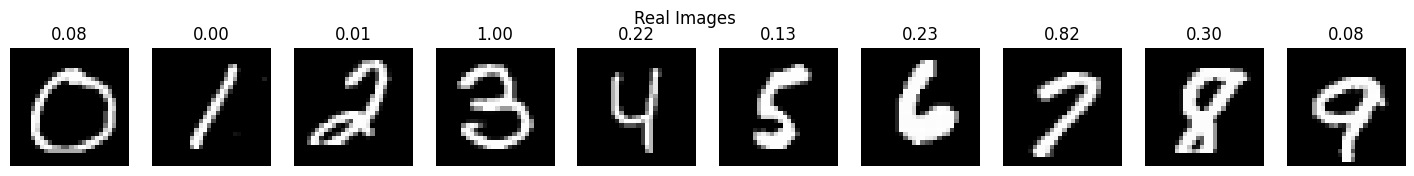

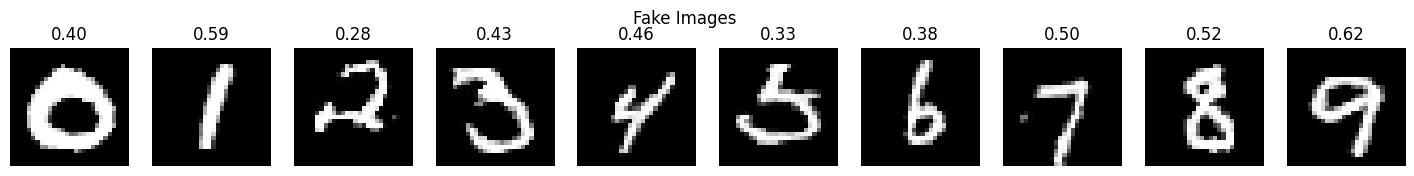

700/700 [==============================] - 1178s 2s/step - g_loss: 0.7497 - d_loss: 0.6793 - r_acc: 0.5162 - f_acc: 0.4815
Epoch 80/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7792 - d_loss: 0.6671 - r_acc: 0.5244 - f_acc: 0.4735

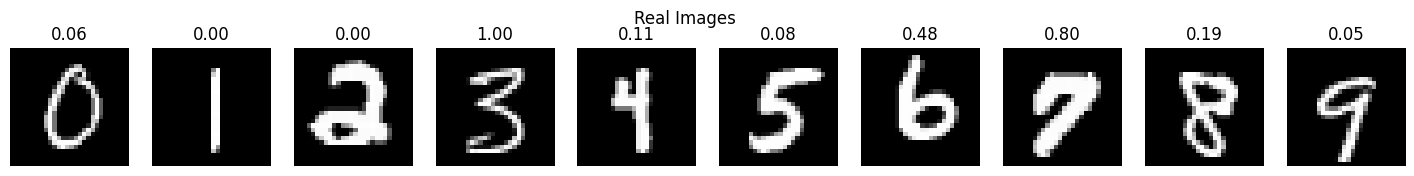

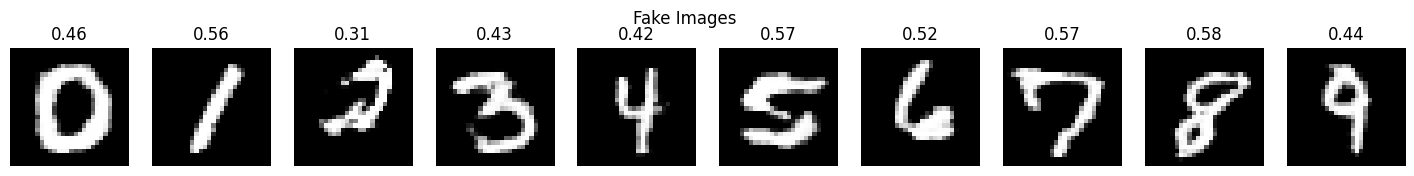

700/700 [==============================] - 52s 74ms/step - g_loss: 0.7792 - d_loss: 0.6671 - r_acc: 0.5244 - f_acc: 0.4735
Epoch 81/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7470 - d_loss: 0.6812 - r_acc: 0.5156 - f_acc: 0.4827

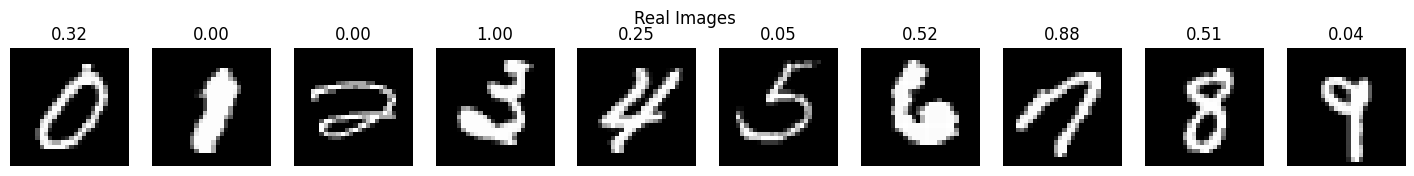

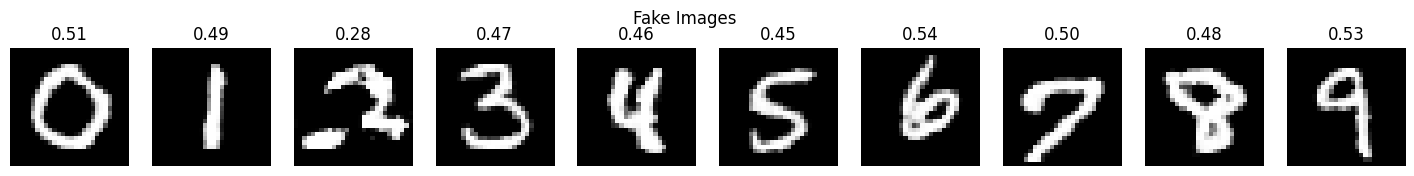

700/700 [==============================] - 52s 74ms/step - g_loss: 0.7470 - d_loss: 0.6812 - r_acc: 0.5156 - f_acc: 0.4827
Epoch 82/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7641 - d_loss: 0.6712 - r_acc: 0.5209 - f_acc: 0.4772

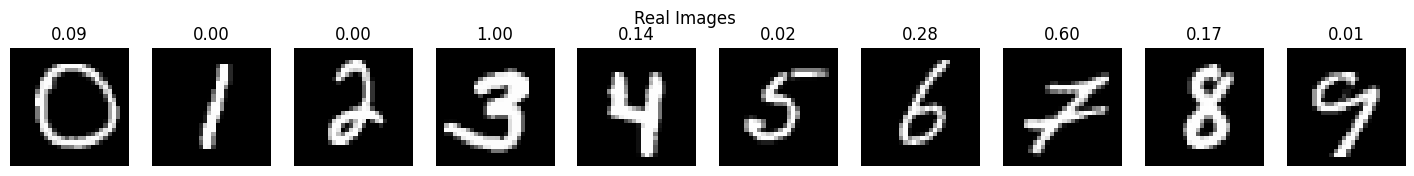

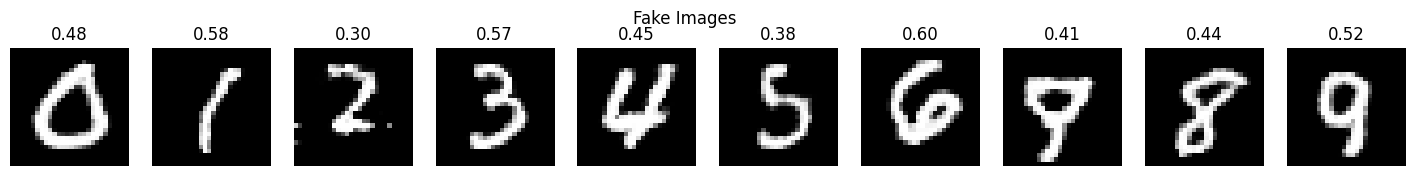

700/700 [==============================] - 52s 75ms/step - g_loss: 0.7641 - d_loss: 0.6712 - r_acc: 0.5209 - f_acc: 0.4772
Epoch 83/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7609 - d_loss: 0.6725 - r_acc: 0.5203 - f_acc: 0.4777

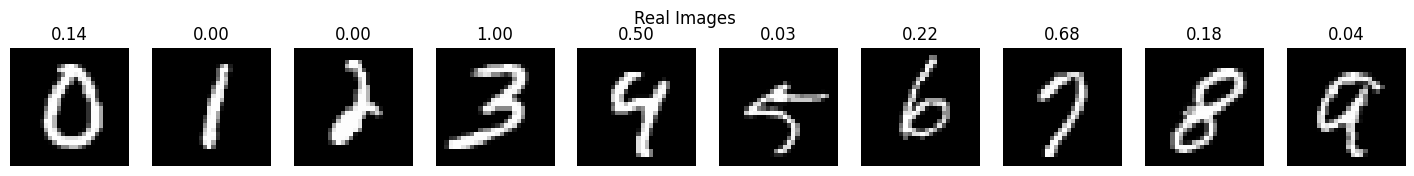

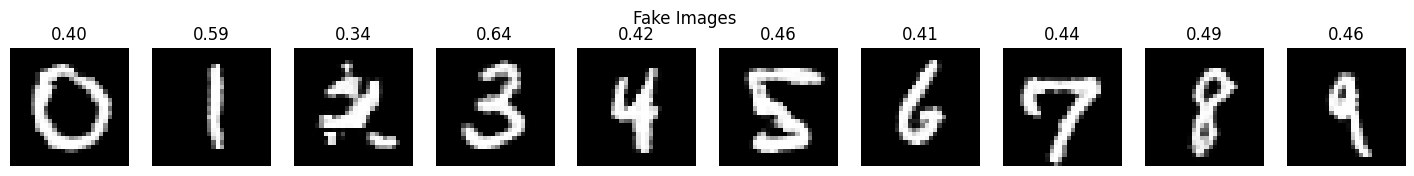

700/700 [==============================] - 53s 76ms/step - g_loss: 0.7609 - d_loss: 0.6726 - r_acc: 0.5203 - f_acc: 0.4777
Epoch 84/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7617 - d_loss: 0.6724 - r_acc: 0.5203 - f_acc: 0.4780

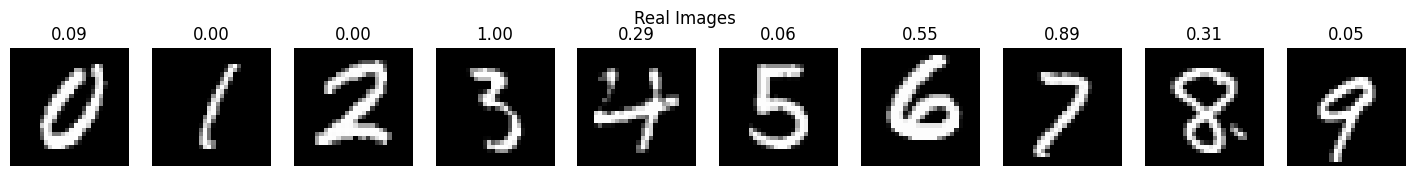

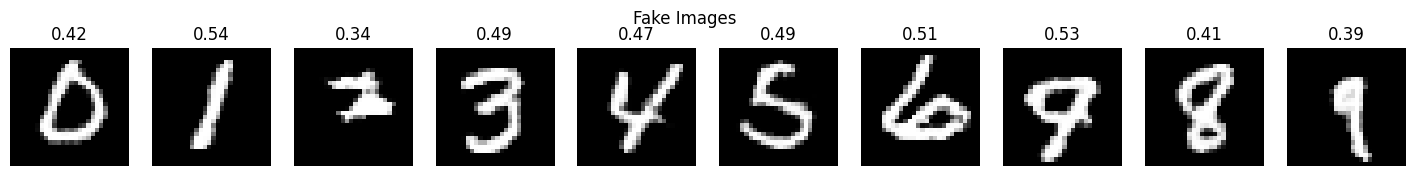

700/700 [==============================] - 53s 76ms/step - g_loss: 0.7617 - d_loss: 0.6724 - r_acc: 0.5203 - f_acc: 0.4780
Epoch 85/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7701 - d_loss: 0.6657 - r_acc: 0.5241 - f_acc: 0.4746

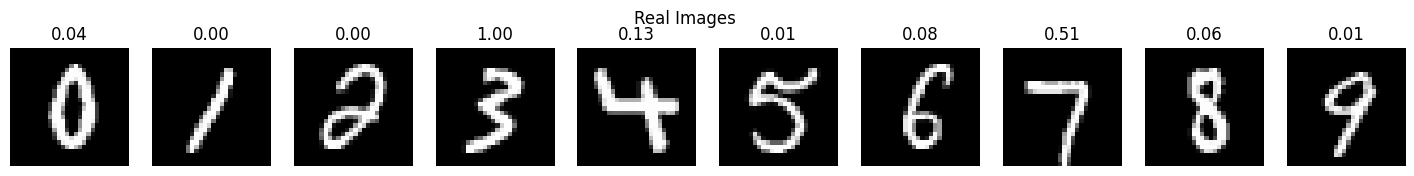

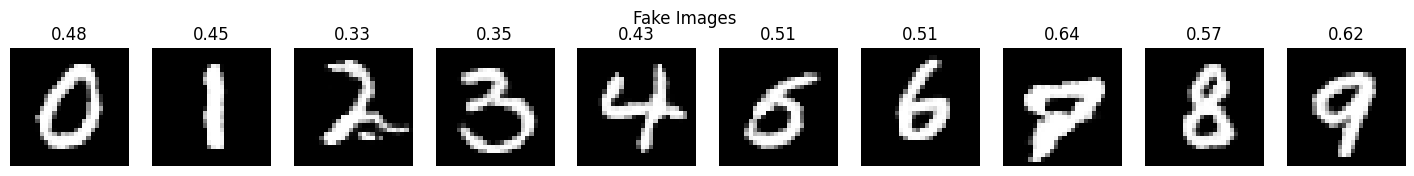

700/700 [==============================] - 52s 75ms/step - g_loss: 0.7700 - d_loss: 0.6657 - r_acc: 0.5241 - f_acc: 0.4746
Epoch 86/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7413 - d_loss: 0.6830 - r_acc: 0.5137 - f_acc: 0.4842

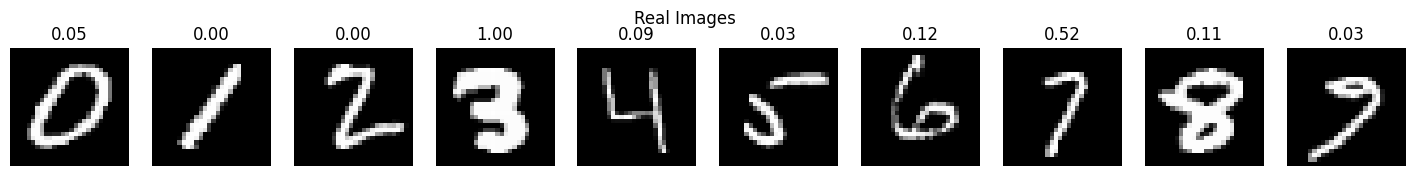

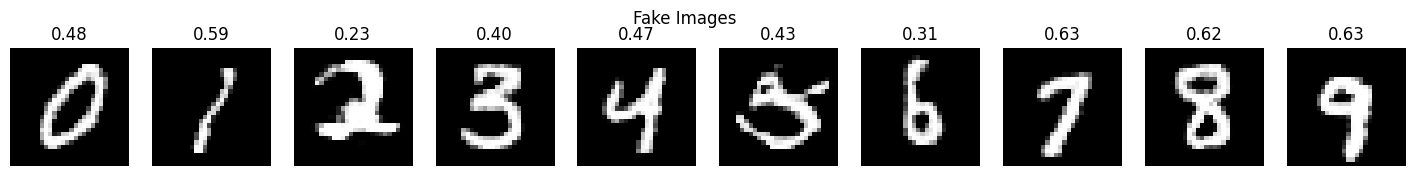

700/700 [==============================] - 53s 76ms/step - g_loss: 0.7413 - d_loss: 0.6830 - r_acc: 0.5137 - f_acc: 0.4842
Epoch 87/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7497 - d_loss: 0.6802 - r_acc: 0.5156 - f_acc: 0.4817

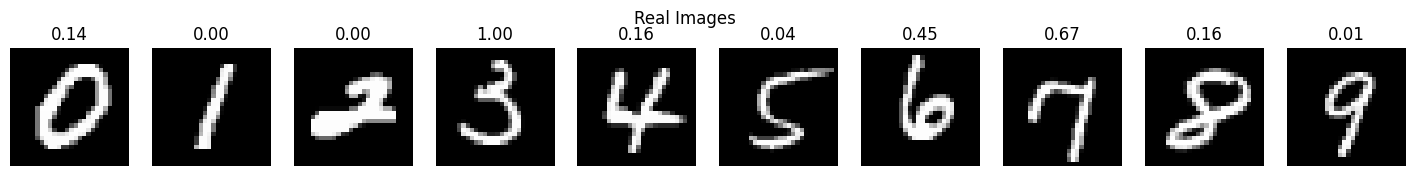

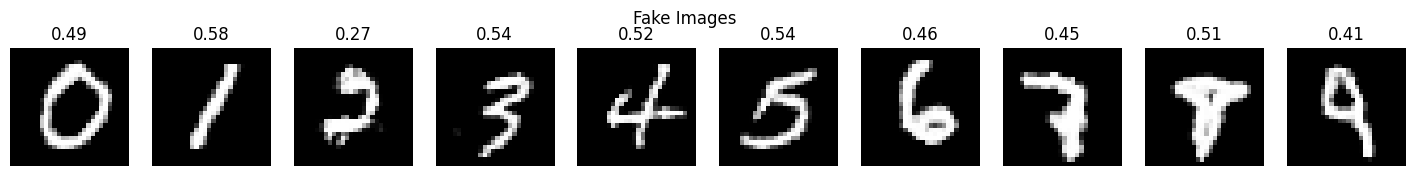

700/700 [==============================] - 53s 76ms/step - g_loss: 0.7497 - d_loss: 0.6802 - r_acc: 0.5156 - f_acc: 0.4817
Epoch 88/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7521 - d_loss: 0.6767 - r_acc: 0.5170 - f_acc: 0.4805

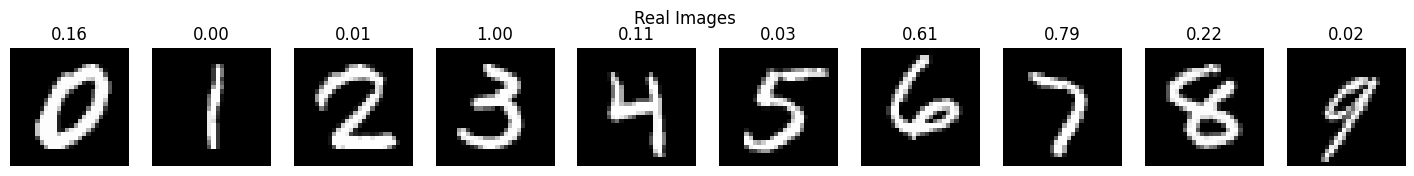

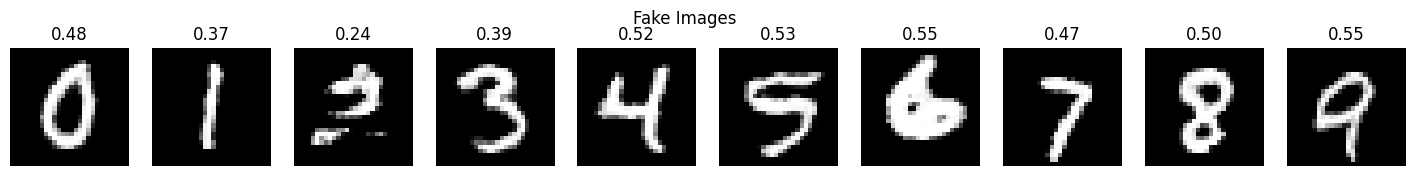

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7521 - d_loss: 0.6767 - r_acc: 0.5170 - f_acc: 0.4805
Epoch 89/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7619 - d_loss: 0.6716 - r_acc: 0.5203 - f_acc: 0.4772

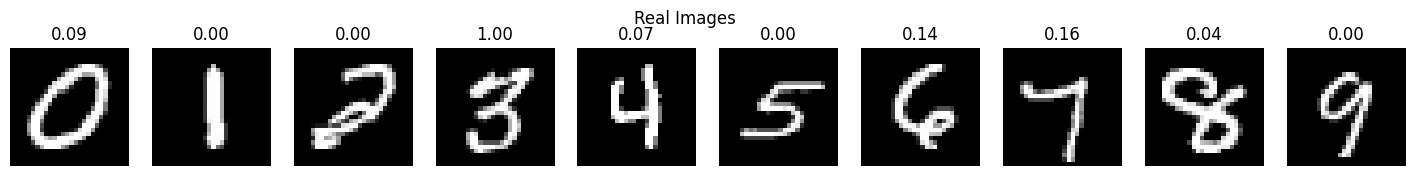

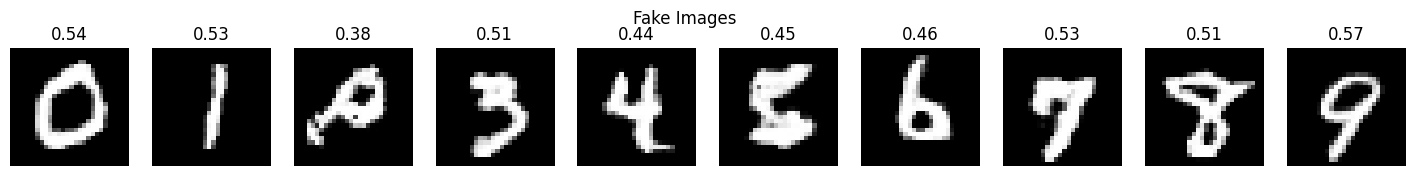

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7619 - d_loss: 0.6716 - r_acc: 0.5203 - f_acc: 0.4772
Epoch 90/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7667 - d_loss: 0.6688 - r_acc: 0.5221 - f_acc: 0.4754

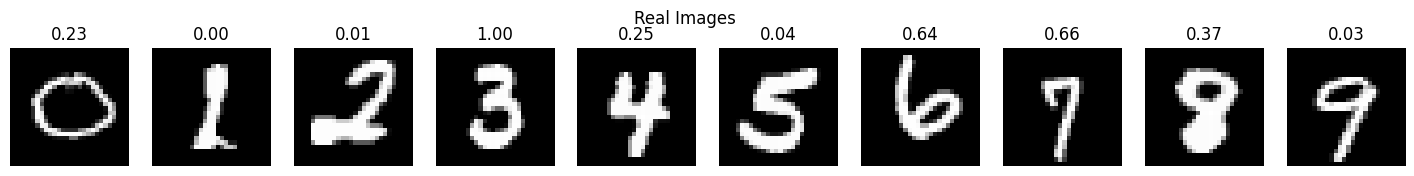

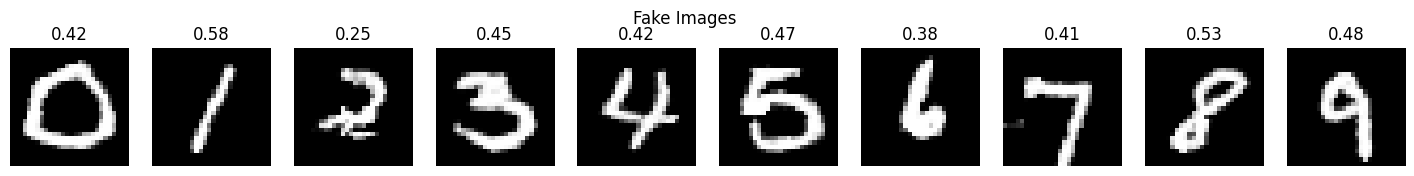

700/700 [==============================] - 53s 76ms/step - g_loss: 0.7667 - d_loss: 0.6688 - r_acc: 0.5221 - f_acc: 0.4754
Epoch 91/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7725 - d_loss: 0.6660 - r_acc: 0.5244 - f_acc: 0.4741

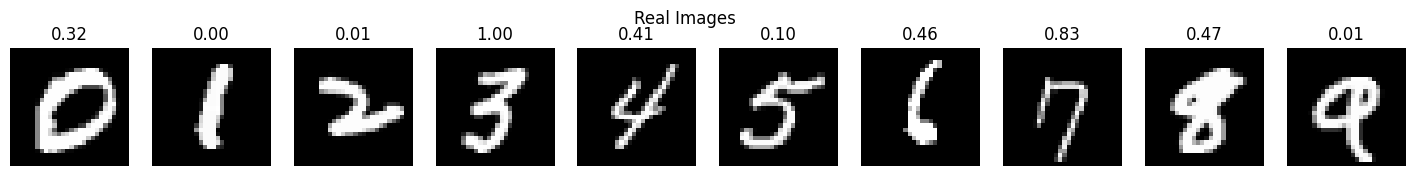

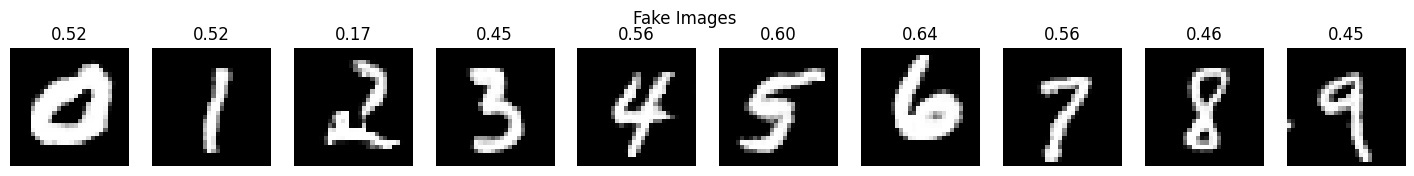

700/700 [==============================] - 906s 1s/step - g_loss: 0.7725 - d_loss: 0.6660 - r_acc: 0.5244 - f_acc: 0.4741
Epoch 92/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7734 - d_loss: 0.6662 - r_acc: 0.5239 - f_acc: 0.4742

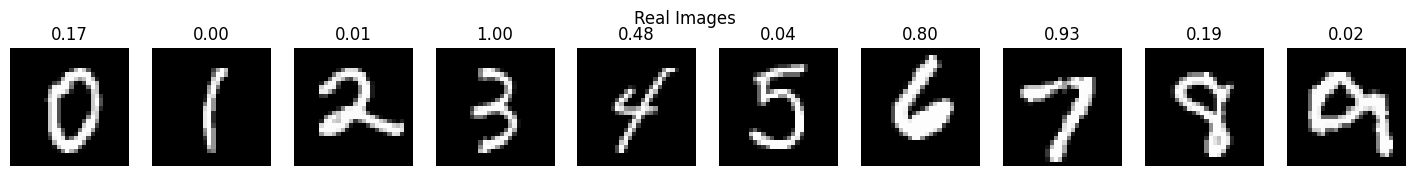

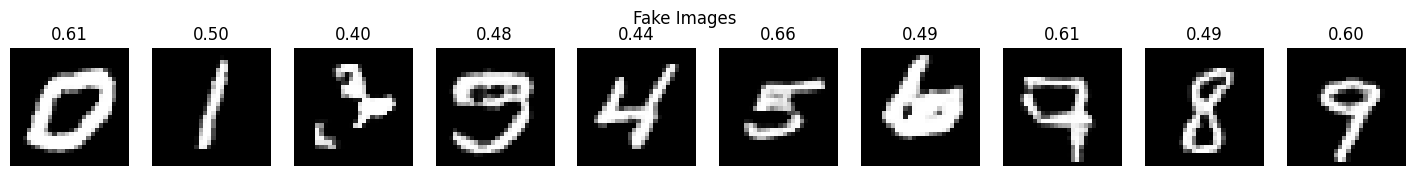

700/700 [==============================] - 52s 74ms/step - g_loss: 0.7734 - d_loss: 0.6662 - r_acc: 0.5239 - f_acc: 0.4742
Epoch 93/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7760 - d_loss: 0.6649 - r_acc: 0.5252 - f_acc: 0.4732

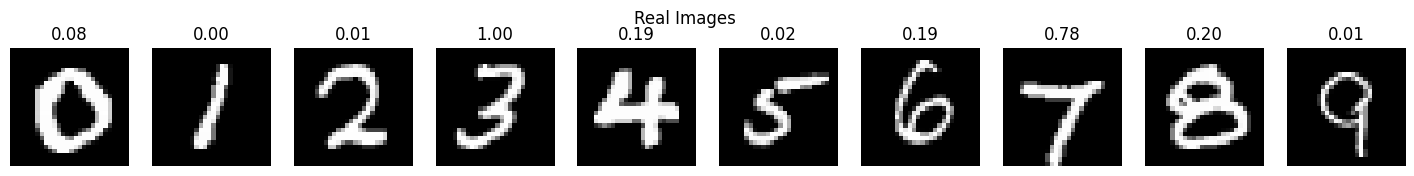

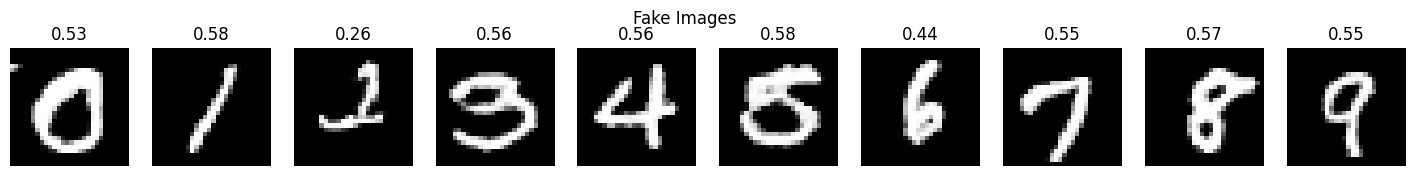

700/700 [==============================] - 52s 75ms/step - g_loss: 0.7760 - d_loss: 0.6649 - r_acc: 0.5252 - f_acc: 0.4732
Epoch 94/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7610 - d_loss: 0.6716 - r_acc: 0.5203 - f_acc: 0.4773

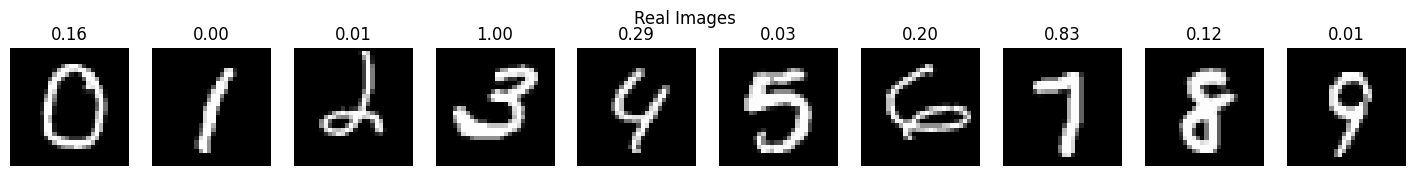

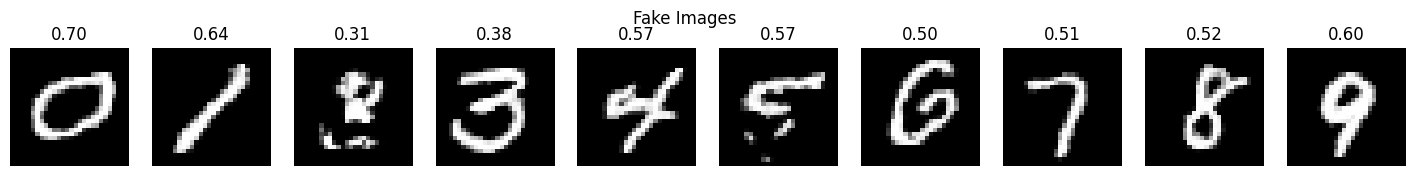

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7610 - d_loss: 0.6716 - r_acc: 0.5204 - f_acc: 0.4773
Epoch 95/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7953 - d_loss: 0.6578 - r_acc: 0.5297 - f_acc: 0.4685

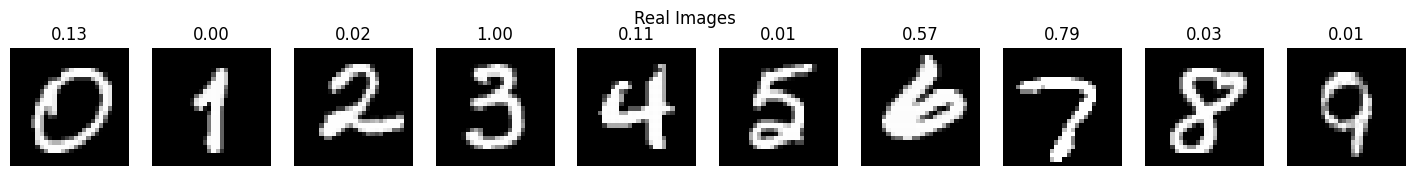

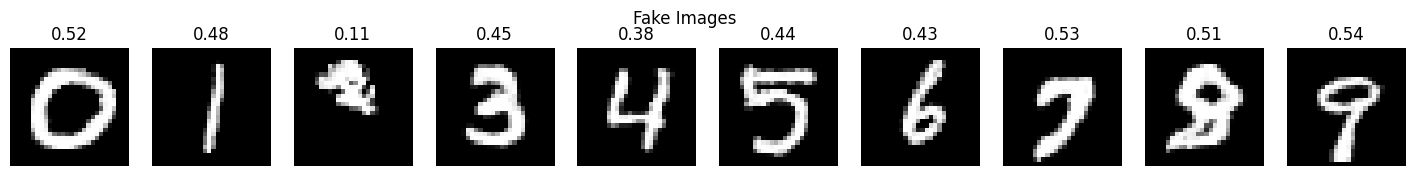

700/700 [==============================] - 53s 76ms/step - g_loss: 0.7954 - d_loss: 0.6578 - r_acc: 0.5297 - f_acc: 0.4685
Epoch 96/100
700/700 [==============================] - ETA: 0s - g_loss: 0.8307 - d_loss: 0.6478 - r_acc: 0.5367 - f_acc: 0.4621

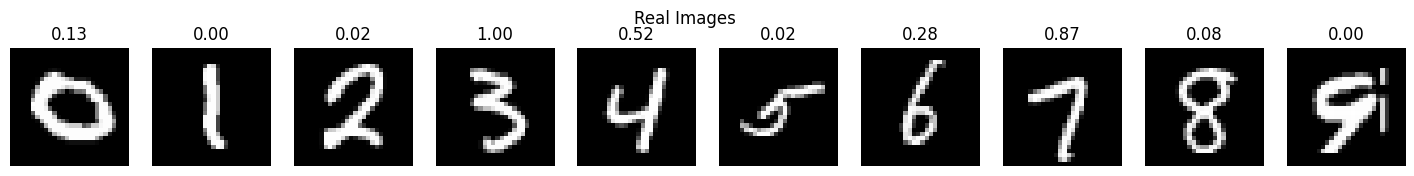

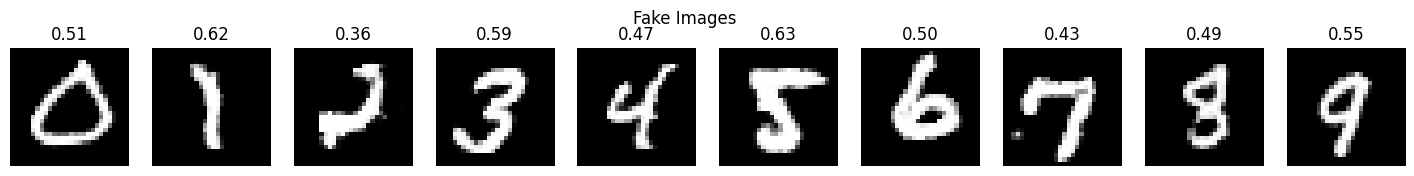

700/700 [==============================] - 53s 76ms/step - g_loss: 0.8307 - d_loss: 0.6478 - r_acc: 0.5367 - f_acc: 0.4621
Epoch 97/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7841 - d_loss: 0.6637 - r_acc: 0.5264 - f_acc: 0.4709

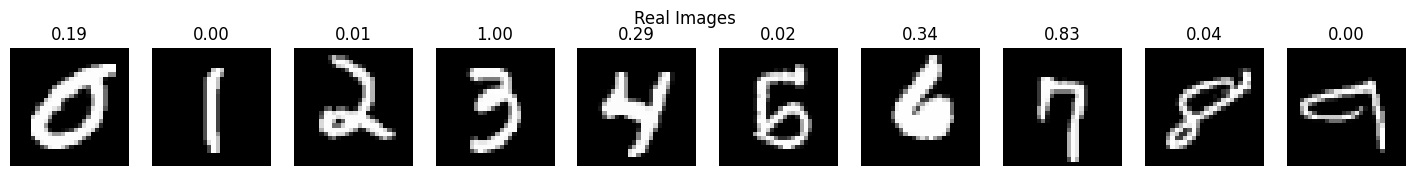

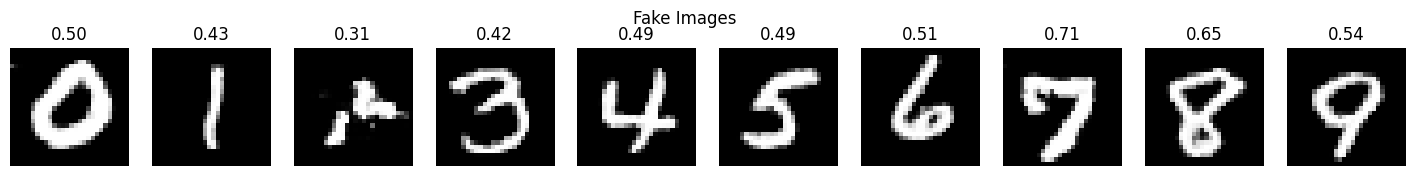

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7841 - d_loss: 0.6637 - r_acc: 0.5264 - f_acc: 0.4709
Epoch 98/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7637 - d_loss: 0.6725 - r_acc: 0.5208 - f_acc: 0.4774

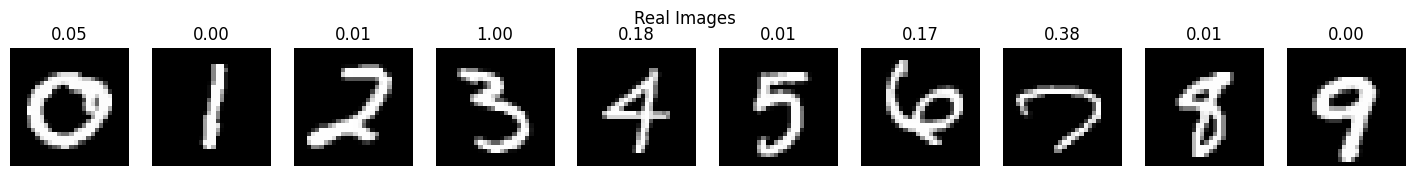

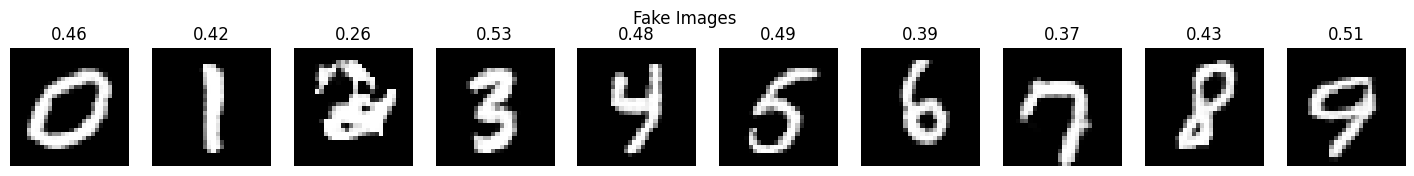

700/700 [==============================] - 54s 77ms/step - g_loss: 0.7637 - d_loss: 0.6725 - r_acc: 0.5208 - f_acc: 0.4773
Epoch 99/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7761 - d_loss: 0.6650 - r_acc: 0.5252 - f_acc: 0.4734

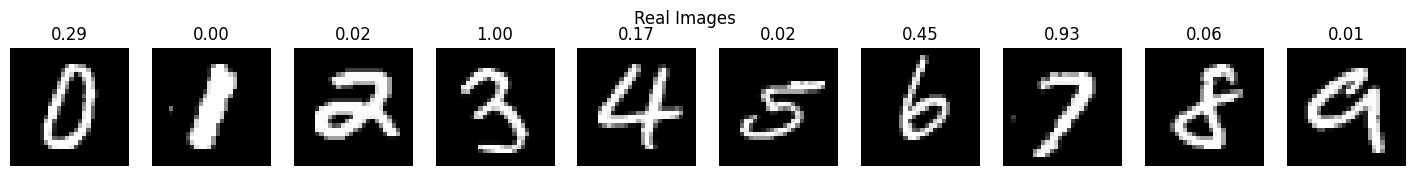

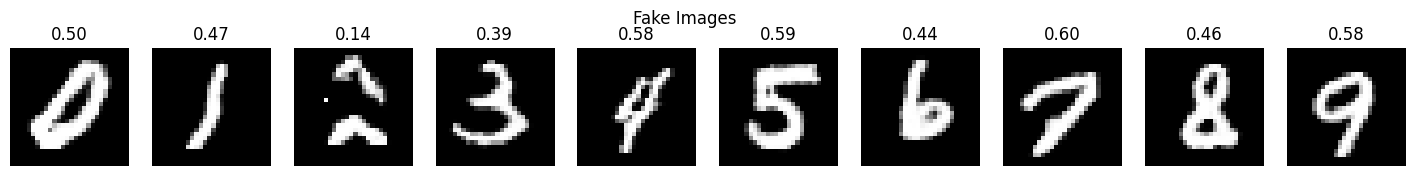

700/700 [==============================] - 93s 133ms/step - g_loss: 0.7761 - d_loss: 0.6650 - r_acc: 0.5252 - f_acc: 0.4734
Epoch 100/100
700/700 [==============================] - ETA: 0s - g_loss: 0.7962 - d_loss: 0.6603 - r_acc: 0.5291 - f_acc: 0.4691

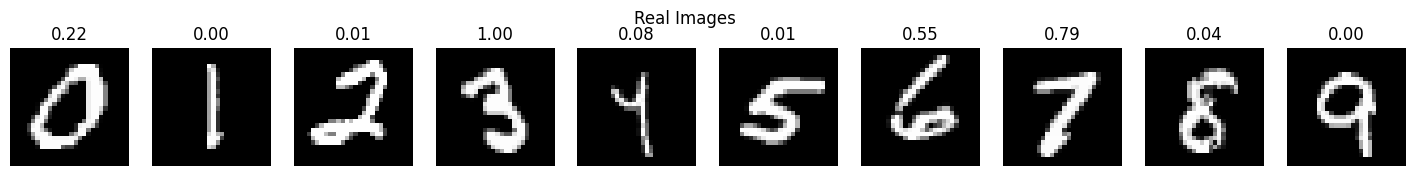

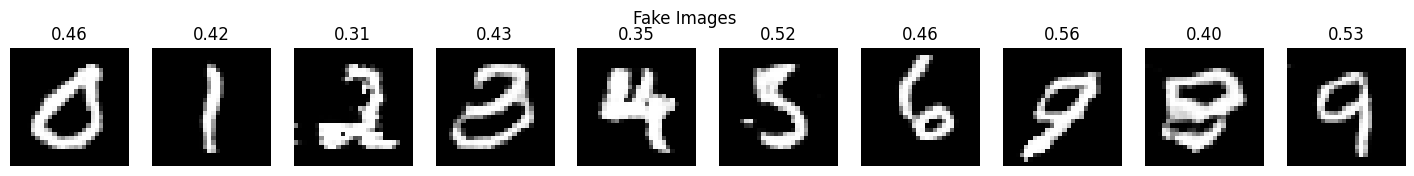

700/700 [==============================] - 56s 80ms/step - g_loss: 0.7962 - d_loss: 0.6603 - r_acc: 0.5291 - f_acc: 0.4691


c:\Users\anant\.conda\envs\gpu-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Initialize the ConditionalGAN with the previously defined discriminator and generator models,
# along with the dimensionality of the latent space.
cond_gan = ConditionalGAN(
    discriminator=discriminator,  # The discriminator model
    generator=generator,  # The generator model
    latent_dim=latent_dim  # Dimensionality of the generator's latent space
)

# Print the summaries of both the generator and discriminator to check their architectures
# and ensure they are correctly set up before starting the training.
cond_gan.generator.summary()
cond_gan.discriminator.summary()

# Compile the ConditionalGAN model with specified optimizers for the discriminator and generator,
# a loss function, and evaluation metrics.
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),  # Optimizer for the discriminator
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0004),  # Optimizer for the generator
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),  # Loss function for binary classification
)

# Start training the model on the provided dataset for a set number of epochs and using
# the custom Visualizer callback for visual feedback on the training progress.
history = cond_gan.fit(
    dataset,  # The training dataset
    epochs=100,  # Number of epochs to train for
    callbacks=[
        Visualizer(
            cond_gan.generator,  # Pass the generator for image generation
            cond_gan.discriminator,  # Pass the discriminator for image evaluation
            all_digits,  # Real images to compare against generated ones
            all_labels_test  # Labels associated with the real images
        )
    ]
)

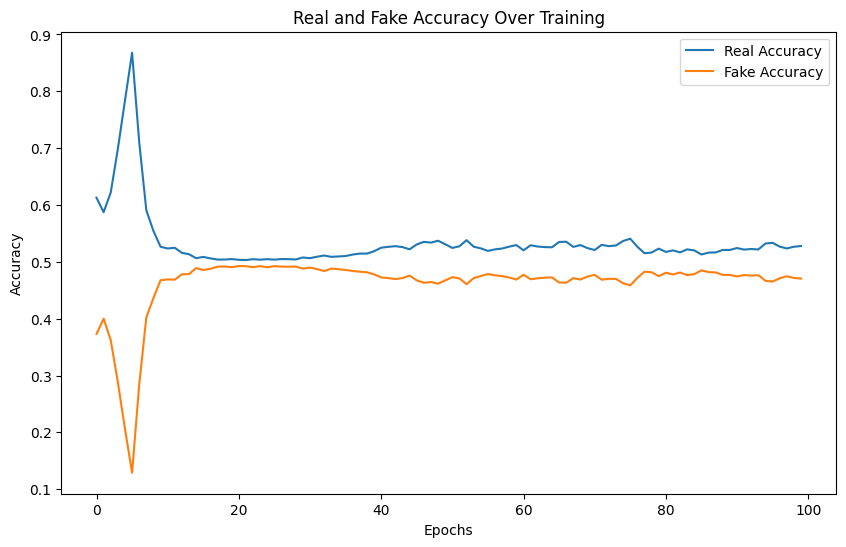

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['r_acc'], label='Real Accuracy')
plt.plot(history.history['f_acc'], label='Fake Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Real and Fake Accuracy Over Training')
plt.legend()
plt.show()

# Testing Model Performace

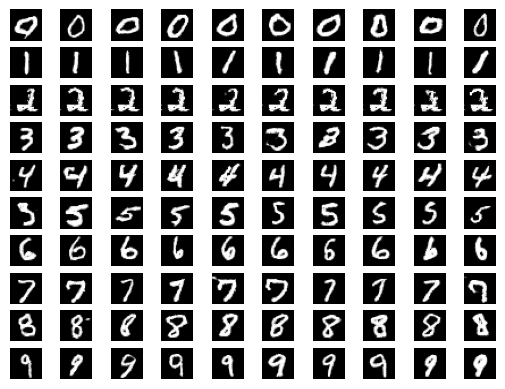

In [11]:
for i in range(10):
    one_hot_labels = tf.one_hot(tf.constant([i,i,i,i,i,i,i,i,i,i]), 10)
    random_latent_vectors = tf.random.normal(shape=(10, 100))
    generated_images = cond_gan.generator(tf.concat([random_latent_vectors, one_hot_labels], axis=-1))
    for j in range(10):
        plt_no = (i*10) + (j+1)
        plt.subplot(10, 10, plt_no)
        plt.imshow(generated_images[j,:,:,0], cmap='gray')
        plt.axis('off')
plt.show()